# Set Up

### Imports

In [4]:
import os, pickle, random, itertools
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import time
import mne
import scipy.stats as stats
from scipy.signal import resample,resample_poly,periodogram,welch,lfilter,filtfilt
# Sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Tensorflow
import tensorflow as tf

LABEL_NAMES = [ "Inactivity",
                "Double Blink", "Look Left", "Look Right", "Look Down", "Look Up",
                "Rotate Head Left", "Rotate Head Right",
                "Unknown"]

Platform: _Windows 10_ <br>
Python: _3.10.11_ <br>
pandas: _v.2.0.2_ <br>
matplotlib: _v.3.7.1_ <br>
numpy: _v.1.24.3_ <br>
scipy: _v.1.10.1_ <br>
mne: _v.1.4.0_ <br>
sklearn: _v.1.2.2_ <br>
tensorflow: _v.2.10.0_

### Plot Functions

- __get_dataframes_by_label()__: _Returns a list of all the dataframes (movements - fragments) of a specific category._<br>
&nbsp;&nbsp;&nbsp;Parameters:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;fragments (_list_): A list containing all the movements fragments.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;fragments_id (_list_): A list containing the labels for each movement in the fragments list.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;selected_label (_int_): The Label (Class ID) you want to use.<br>
&nbsp;&nbsp;&nbsp;Returns:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(_list_): All the dataframes of the Class ID you choose.<br>
&nbsp;&nbsp;&nbsp;Example Usage: <span style="color:green"> double_blink_dataframes = get_dataframes_by_label(fragments, fragments_id, 1)<br> <span>

- __plot_signals_comparison()__: _Plot a comparison of multiple signals in both time domain and frequency domain (using PSD)._<br>
&nbsp;&nbsp;&nbsp;Parameters:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;signals (_list of numpy arrays_): A list of signals to be plotted.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;names (_list of str_): A list of names corresponding to each signal.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;fs (_int_): The sampling rate of the signals.<br>
&nbsp;&nbsp;&nbsp;Raises:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;_ValueError_: If the number of signals does not match the number of names.<br>
&nbsp;&nbsp;&nbsp;Returns:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;_None_<br>

In [ ]:
def get_dataframes_by_label(fragments, fragments_id, selected_label):
    return [fragments[i] for i, label in enumerate(fragments_id) if label == selected_label]

def plot_signals_comparison(signals, names, fs):
    if len(signals) != len(names): raise ValueError("Number of signals must match the number of names.")

    plt.figure(figsize=(12, 8))
    plt.style.use("ggplot")

    # Plot in time domain (first subplot)
    plt.subplot(2, 1, 1)
    for i, signal in enumerate(signals):
        plt.plot(signal, label=names[i])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Comparison of Signals in Time Domain')
    plt.legend()
    plt.grid(True)

    # Plot in frequency domain (second subplot)
    plt.subplot(2, 1, 2)
    for i, signal in enumerate(signals):
        freq, psd = plt.psd(signal, NFFT=len(signal), Fs=fs, label=names[i])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.title('Power Spectral Density of Signals')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_movement(dataframe, channels, fs=256, save_dir = None, filename = None):
    plt.style.use('default')
    #channels = ['AF7', 'AF8', 'TP9', 'TP10', 'X', 'Y', 'Z']
    time = np.linspace(0, len(dataframe) / fs, len(dataframe))

    fig, axs = plt.subplots(4, 2, figsize=(20, 15))
    axs = axs.ravel()  # Flatten the 2D array of axes

    for i, channel in enumerate(channels):
        # Determine color based on channel type
        color = 'blue' if channel in ['AF7', 'AF8', 'TP9', 'TP10'] else 'black'

        axs[i].plot(time, dataframe[channel], label=channel, color=color)
        axs[i].set_title(channel)
        axs[i].set_xlabel("Time (s)")
        axs[i].grid(True, color='black', linestyle=':')  # Apply grid

        # Set y-axis limits
        if channel in ['AF7', 'AF8']:
            axs[i].set_ylim([-150, 150])  # Adjust EEG limits as needed
        elif channel in ['TP9', 'TP10']:
            axs[i].set_ylim([-400, 400])  # Adjust EEG limits as needed
        else:
            axs[i].set_ylim([-150, 150])  # Adjust gyro limits as needed
        axs[i].legend()

    # For the last subplot, compute and plot the PSD using Welch's method
    for channel in channels:
        freqs, Pxx = plt.psd(dataframe[channel], NFFT=len(dataframe[channel]), Fs=fs,label=channel)

    axs[-1].set_title("Power Spectral Density (PSD)")
    axs[-1].set_xlabel("Frequency (Hz)")
    axs[-1].set_ylabel("Power/Frequency (dB/Hz)")
    axs[-1].set_xlim([0, fs/2])
    #axs[-1].set_ylim([-60, 60])
    axs[-1].grid(True)
    axs[-1].legend(loc='lower right')
    axs[-1].set_facecolor("azure")

    # Saving plot
    if(save_dir and filename):
        plt.ioff()
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
        plt.close()
    # Show plot
    else:
        plt.ioff()
        plt.tight_layout()
        plt.show()

def plot_history_metrics(history: tf.keras.callbacks.History, val_split=False, metrics_to_plot=None):
    """
    Function to plot all the metrics present in a keras.callbacks.History
    """
    plt.style.use("ggplot")

    if metrics_to_plot is None:
        # if no specific metrics are provided, plot all metrics
        metrics_to_plot = list(history.history.keys())

    if(val_split):
        total_plots = len(metrics_to_plot)//2
    else:
        total_plots = len(metrics_to_plot)

    cols = total_plots // 2
    rows = total_plots // cols
    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))

    if(val_split):
        for i in range(0, len(metrics_to_plot)//2):
            key = metrics_to_plot[i]
            key_val = metrics_to_plot[i + len(metrics_to_plot)//2]
            value = history.history[key]
            val_value = history.history[key_val]
            plt.subplot(rows, cols, pos[i])
            plt.plot(range(len(value)), value, label = key)
            plt.plot(range(len(val_value)), val_value, label = key_val)
            plt.title(str(key))
            plt.legend()
    else:
        for i, key in enumerate(metrics_to_plot):
            value = history.history[key]
            plt.subplot(rows, cols, pos[i])
            plt.plot(range(len(value)), value)
            plt.title(str(key))
    plt.show()

def plot_Confusion_Matrix(true_labels, prediction_labels, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    if (len(true_labels)==len(prediction_labels)):
        cm = confusion_matrix(y_true=true_labels,y_pred=prediction_labels)

        counter = 0
        for i in range(len(true_labels)):
            if(true_labels[i]==prediction_labels[i]): counter +=1
        print("\nCorrect predictions: " + str(counter)+"/"+str(len(true_labels)))
        plt.figure(figsize=(12, 8))
        plt.style.use("ggplot")
        plt.grid(False)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90)
        plt.yticks(tick_marks, classes)
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    else: print("true_labels lenght != prediction_labels lenght")

__________________________________________________________________________________________________________________________________

# Signal Segmentation

In this step, we use the __segmentation.py__ script to manually create epochs(segments) from the Raw EEG & Gyroscope sessions.<br>
Each segment represents a specific movement and it is saved as a DataFrame with a label in a pickle file (.pkl).<br>
Each .pkl file then stored in a folder (__MY_DATA/Labeled_Fragments__). Here we use a __3sec__ window for each segment.<br>
So, each __.pkl__ file contains __fragments__ (dataframes) and __fragments_id__ (the label for each dataframe).<br>

To create epochs (manually) run the __segmentation.py__ script in the __tools__ folder : <span style="color:blue">*python .\segmentation.py* <br></span>
<span style="color:blue">
*Enter a file path:_ ...\RAW_MUSE_DATA\Sessions_EEG_GS\user_1\double_tap\ID78\EEG2_GYRO2.csv*<br>
*Enter filename: name_of_pkl_file*
</span>

__________________________________________________________________________________________________________________________________

# Loading Raw Data Fragments

__Εye and Ηead movements with Category ID (MUSE):__

    Movement Type:    |  Class ID:
    Inactivity        |  0
    Double blink      |  1
    Look Left         |  2
    Look Right        |  3
    Look Down         |  4
    Look Up           |  5
    Rotate Head Left  |  6
    Rotate Head Right |  7
    Unknown/Noise     |  8

- __load_raw_fragments()__:

In [ ]:
def load_raw_fragments(file_path, label_names, choose_user = None, show_plot = False):
    # Initialize lists
    fragments, fragments_id = [], []

    for file in os.listdir(file_path):
        if choose_user and not file.startswith(choose_user):
            continue
        try:
            with open(file_path + "\\" + file,'rb') as f:
                fragment_dict = pickle.load(f)
                for fragment in fragment_dict["df_lsit"]:
                    fragments.append(fragment)
                for label in fragment_dict["df_labels"]:
                    fragments_id.append(int(label))
        except ValueError:
            print("Oops! There was a problem with file: " + file)


    counts = Counter(fragments_id)
    frequency_names_list = [(name, counts[i]) for i, name in enumerate(label_names)]
    names, frequencies = zip(*frequency_names_list)
    if (choose_user): print(choose_user, names, frequencies)
    else: print(names, frequencies)
    if(show_plot):
        # Create data Plot
        plt.figure(figsize=(10,6))
        bars = plt.bar(names, frequencies)

        plt.xlabel('Categories')
        plt.ylabel('Number of Moves')
        plt.title('Number of Moves for Each Category')
        plt.xticks(rotation=50)
        for bar, frequency in zip(bars, frequencies): # Add the data value on top of each bar
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(frequency), ha='center', va='bottom')

        total_movements_patch = mpatches.Patch(label='Total movements: ' + str(len(fragments)))
        plt.legend(handles=[total_movements_patch], loc='upper right')
        plt.grid(axis="y")
        plt.show()

    return fragments, fragments_id

Loading all the dataframes with their labels in 2 lists (`fragments`, `fragments_id`) from the __.pkl__ files.<br><br>
After Loading . . .<br>
- We can access a sample from the whole dataset like this:<br>
`sample_dataframe = fragments[i]`<br>
`sample_label = fragments_id[i]`<br>
where `i` from `0` to `1097`.
- We can access the data for each user like this:<br>
`user1_fragments = data_per_user['user1']['fragments']`<br>
`user1_fragments_id = data_per_user['user1']['fragments_id']`<br>

('Inactivity', 'Double Blink', 'Look Left', 'Look Right', 'Look Down', 'Look Up', 'Rotate Head Left', 'Rotate Head Right', 'Unknown') (250, 90, 85, 86, 86, 85, 93, 89, 234)


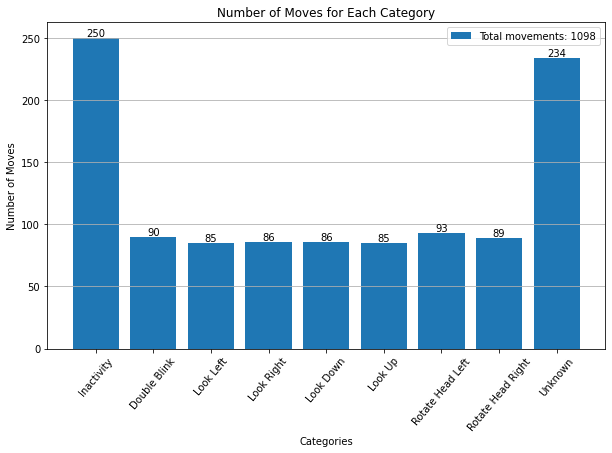

user1 ('Inactivity', 'Double Blink', 'Look Left', 'Look Right', 'Look Down', 'Look Up', 'Rotate Head Left', 'Rotate Head Right', 'Unknown') (32, 12, 9, 12, 12, 12, 12, 12, 26)
user2 ('Inactivity', 'Double Blink', 'Look Left', 'Look Right', 'Look Down', 'Look Up', 'Rotate Head Left', 'Rotate Head Right', 'Unknown') (34, 12, 12, 10, 11, 11, 12, 12, 21)
user3 ('Inactivity', 'Double Blink', 'Look Left', 'Look Right', 'Look Down', 'Look Up', 'Rotate Head Left', 'Rotate Head Right', 'Unknown') (54, 12, 12, 12, 12, 11, 15, 12, 38)
user4 ('Inactivity', 'Double Blink', 'Look Left', 'Look Right', 'Look Down', 'Look Up', 'Rotate Head Left', 'Rotate Head Right', 'Unknown') (26, 12, 12, 12, 11, 11, 12, 12, 68)
user5 ('Inactivity', 'Double Blink', 'Look Left', 'Look Right', 'Look Down', 'Look Up', 'Rotate Head Left', 'Rotate Head Right', 'Unknown') (33, 18, 18, 16, 18, 20, 18, 17, 26)
user6 ('Inactivity', 'Double Blink', 'Look Left', 'Look Right', 'Look Down', 'Look Up', 'Rotate Head Left', 'Rotate 

In [ ]:
%matplotlib inline

# Set Directory/Folder paths
FRAGMENTS_FOLDER_PATH = "MY_DATA\Labeled_Fragments"

# Load Data from all users
fragments, fragments_id = load_raw_fragments(FRAGMENTS_FOLDER_PATH, LABEL_NAMES, show_plot = True)

# Load Data from each user
USERS = ['user1', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7']
data_per_user = {}
for user in USERS:
    user_fragments, user_fragments_id = load_raw_fragments(FRAGMENTS_FOLDER_PATH, LABEL_NAMES, choose_user=user, show_plot=False)
    data_per_user[user] = {'fragments': user_fragments, 'fragments_id': user_fragments_id}

__________________________________________________________________________________________________________________________________

# Signal Analysis

### Create diagrams
From each user, the first three movements of each category are randomly selected in order to be studied through diagrams in time domain and frequency domain.

In [ ]:
USERS = ['user1', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7']
LABEL_NAMES = [ "Inactivity",
                "Double Blink", "Look Left", "Look Right", "Look Down", "Look Up",
                "Rotate Head Left", "Rotate Head Right",
                "Unknown"]

for user in USERS:
    for i in range(8): # For all categories except Unknonw
        for j in range(3): # Take the first 3 moves of the category
            filename = user + "_" + LABEL_NAMES[i] + "_" + str(j) + ".png"

            movement = get_dataframes_by_label(
                data_per_user[user]['fragments'], # Dataframe
                data_per_user[user]['fragments_id'], # Label
                i)[j] # Category (i) and number of moves of this category (j)

            plot_movement(movement,channels=['AF7', 'AF8', 'TP9', 'TP10', 'X', 'Y', 'Z'],save=True,save_dir = "Images/movement_diagrams",filename=filename)

# Preprocessing

- Applying processing steps to an EEG signal to show the preprocessing flow:

Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 169 samples (0.660 sec)



C:\Users\nikos\AppData\Local\Temp\ipykernel_2748\1998437055.py:14: UserWarning: The figure layout has changed to tight
  mne.viz.plot_filter(filter_coeffs, sfreq=256, freq =[0, 20, 25, nyq], gain = [1, 1, 0, 0], plot=('time', 'magnitude', 'delay'))


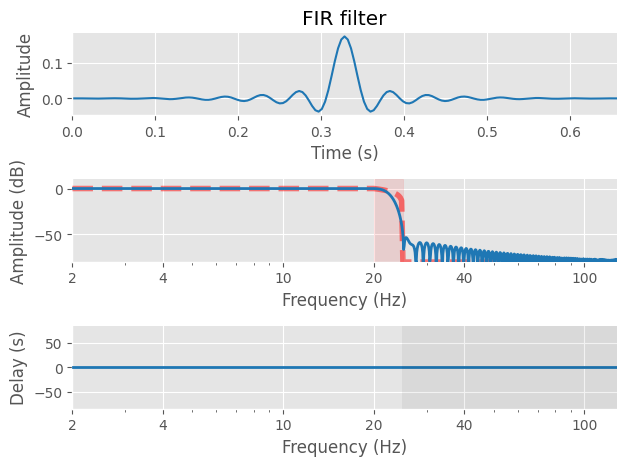

Filtering


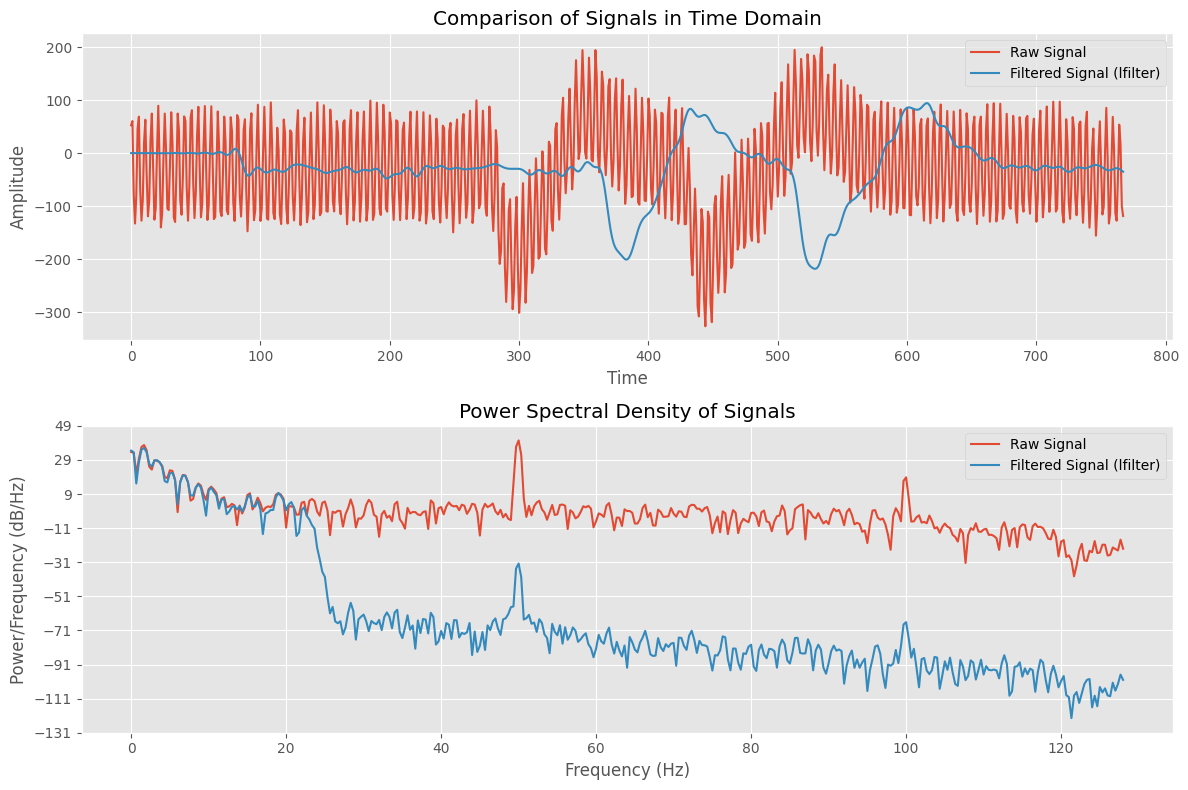

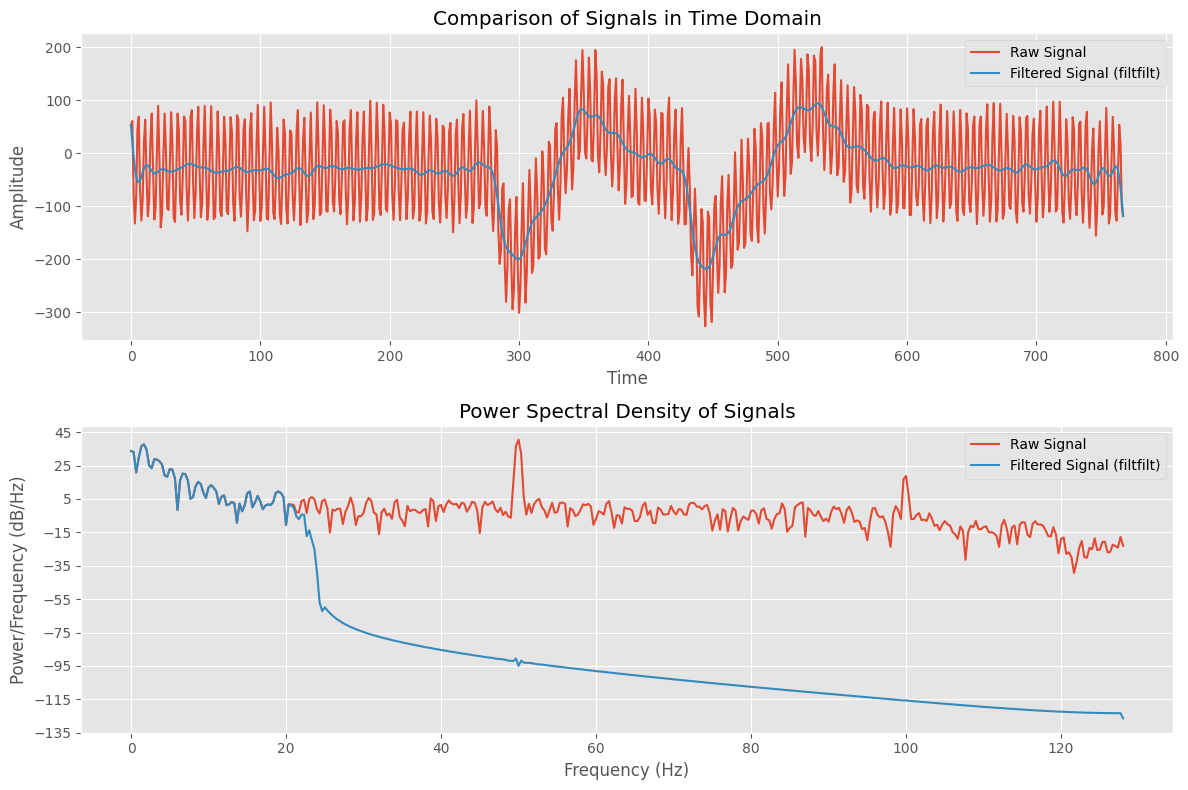

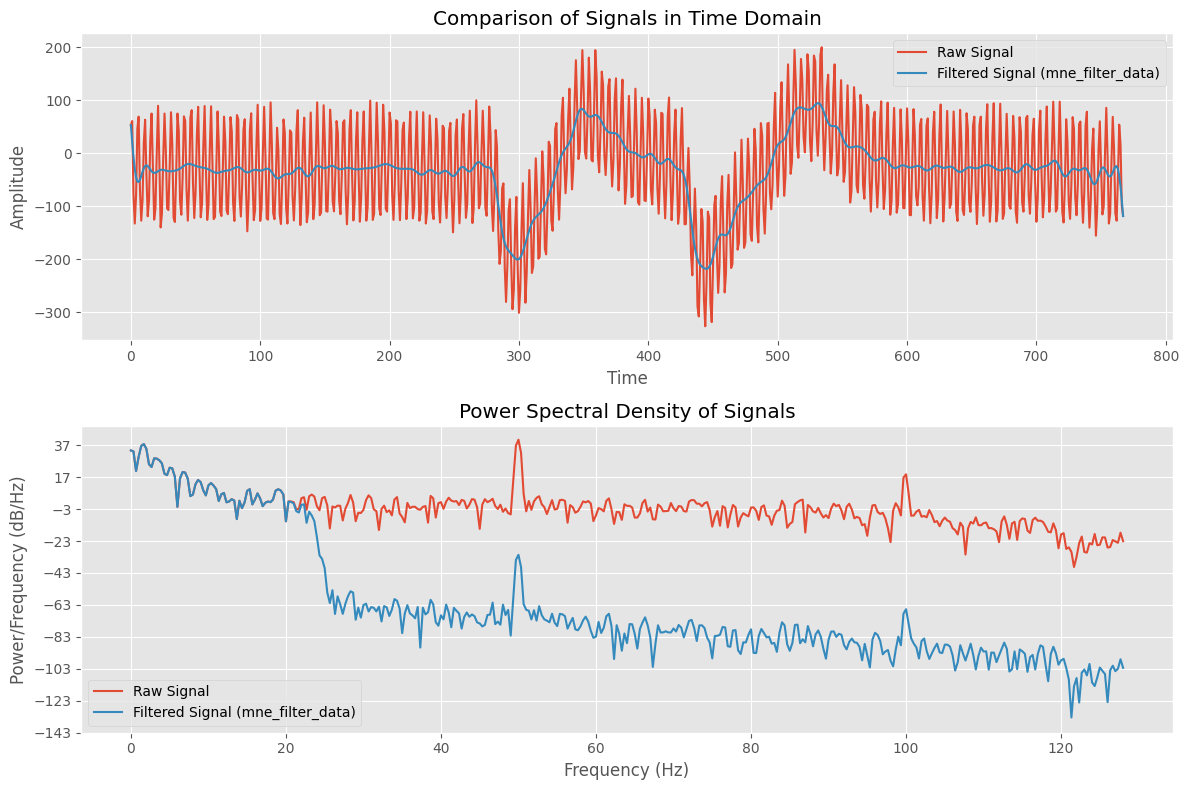

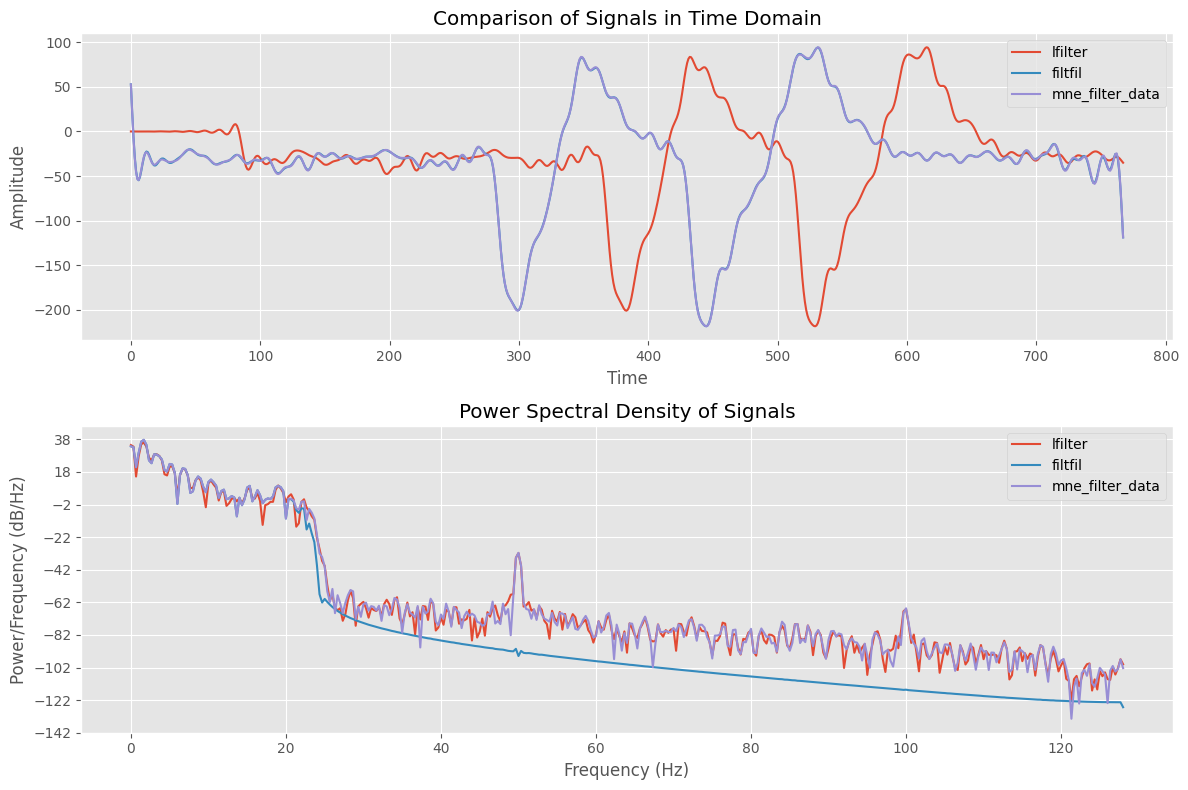

Remove DC Offset


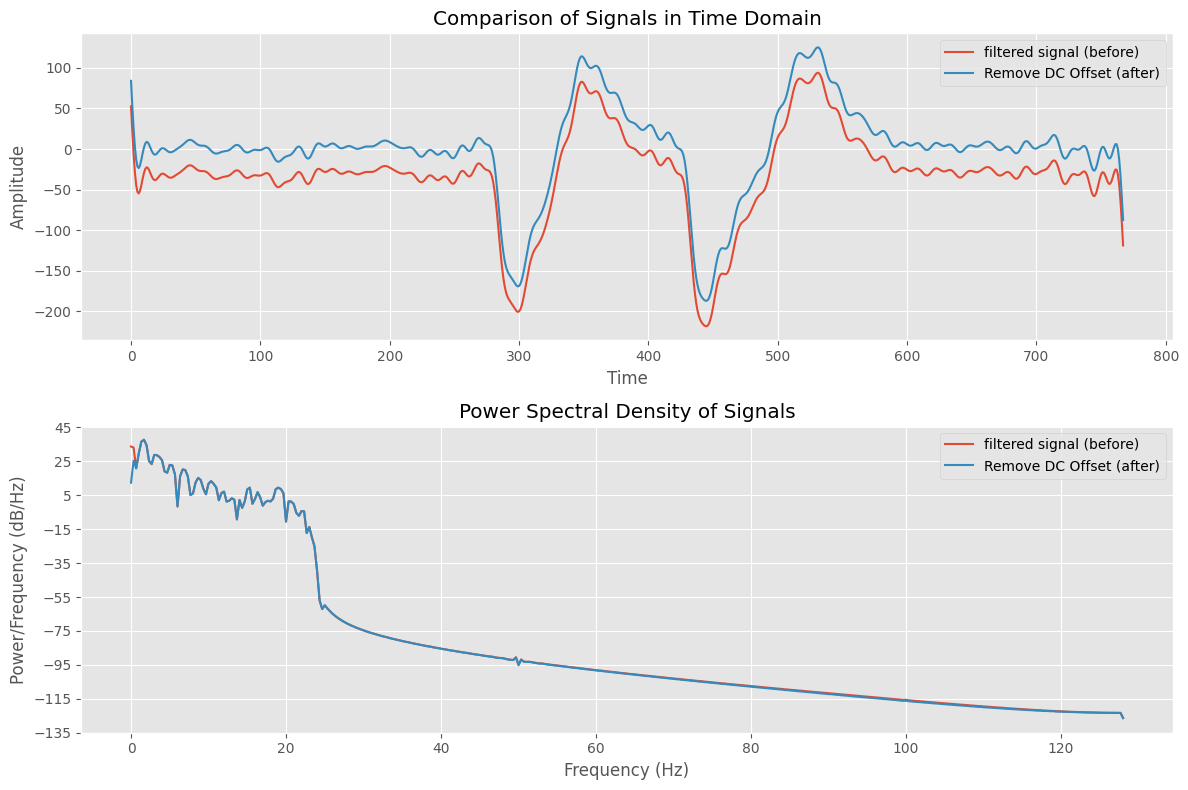

Resample


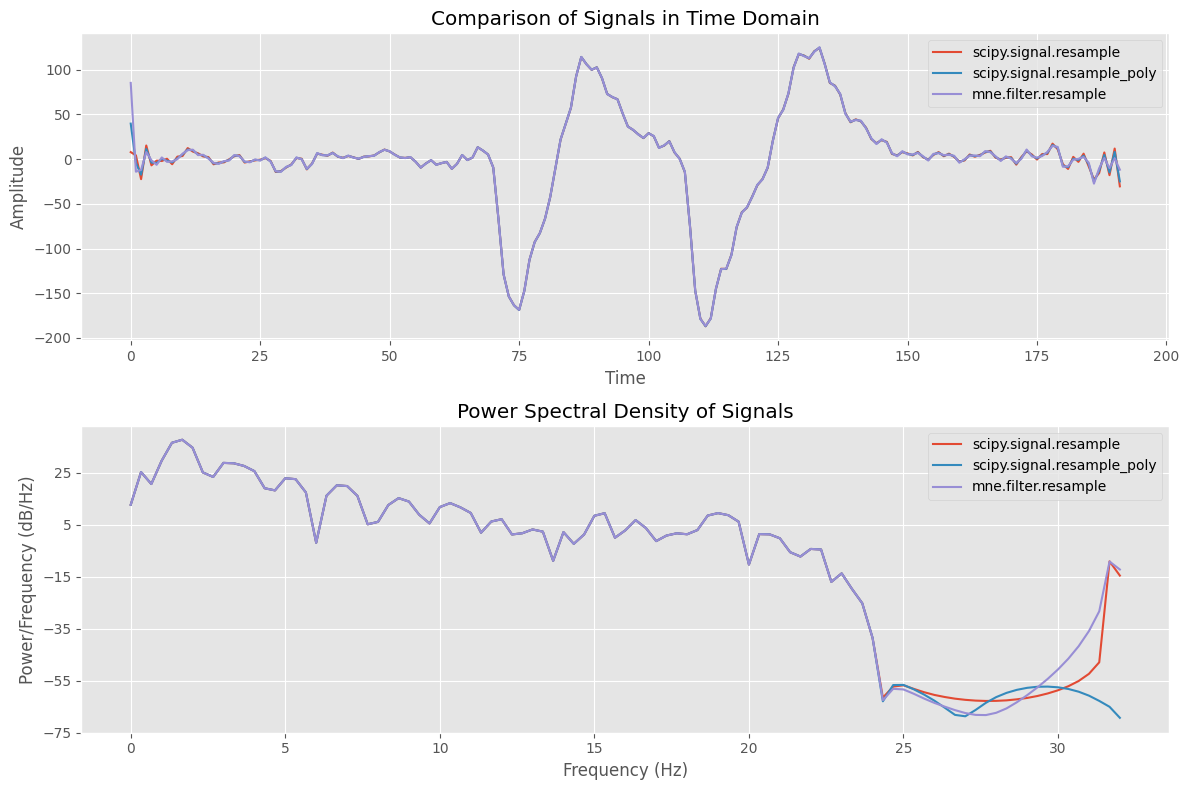

In [ ]:
# Here we take as example the TP10 signal from a Double Blink movement.
raw_signal = get_dataframes_by_label(fragments, fragments_id, 1)[0]["TP9"]
raw_signal = raw_signal.values

########################################################################################################################

# Design a lowpass FIR filter at 20Hz using MNE and save the filter coefficients (1D ndarray for FIR filter)
filter_coeffs = mne.filter.create_filter(raw_signal, sfreq = 256, l_freq=None, h_freq=20,
                                        fir_design='firwin', fir_window='hamming', filter_length='auto')
# Plot the filter properties
nyq = 256 / 2.0  # the Nyquist frequency is half our sample rate
#freq = [0, f_p, f_s, nyq]
#gain = [1, 1, 0, 0]
mne.viz.plot_filter(filter_coeffs, sfreq=256, freq =[0, 20, 25, nyq], gain = [1, 1, 0, 0], plot=('time', 'magnitude', 'delay'))

# Check differnet functions to apply the filter coefficients to the signal
print("Filtering")
# Apply the filter using scipy.signal.lfilter()
filtered_signal_lfilter = lfilter(filter_coeffs, [1.0], raw_signal) # lfilter() is causal and may introduce a phase shift

# Apply the filter using scipy.signal.filtfilt()
filtered_signal_filtfilt = filtfilt(filter_coeffs, [1.0], raw_signal) # filtfilt() is non-causal and zero-phase.

# Apply the filter mne.filter.filter_data() with phase='zero'
filtered_signal_mne_filter_data = mne.filter.filter_data(raw_signal,
                                                    sfreq = 256, l_freq = None, h_freq = 20,
                                                    fir_design='firwin', fir_window='hamming', filter_length='auto', phase='zero', # phase='zero-double' is the same as filtfilt()
                                                    verbose = 'error')

plot_signals_comparison([raw_signal,filtered_signal_lfilter],["Raw Signal","Filtered Signal (lfilter)"],fs=256)
plot_signals_comparison([raw_signal,filtered_signal_filtfilt],["Raw Signal","Filtered Signal (filtfilt)"],fs=256)
plot_signals_comparison([raw_signal,filtered_signal_mne_filter_data],["Raw Signal","Filtered Signal (mne_filter_data)"],fs=256)
plot_signals_comparison([filtered_signal_lfilter,filtered_signal_filtfilt,filtered_signal_mne_filter_data],["lfilter","filtfil","mne_filter_data"],fs=256)

########################################################################################################################

print("Remove DC Offset")
dc_offset_removed_signal = filtered_signal_filtfilt - np.mean(filtered_signal_filtfilt)
plot_signals_comparison([filtered_signal_filtfilt,dc_offset_removed_signal],["filtered signal (before)","Remove DC Offset (after)"],fs=256)

########################################################################################################################

resampled_signal_1 = resample(dc_offset_removed_signal, int(len(dc_offset_removed_signal) * 64/256)) # Using scipy.signal.resample
resampled_signal_2 = resample_poly(dc_offset_removed_signal, 64, 256) # Using scipy.signal.resample_poly
resampled_signal_3 = mne.filter.resample(dc_offset_removed_signal, 64, 256) # Using mne.filter.resample (is the same with scipy.signal.resample)


print("Resample")
plot_signals_comparison([resampled_signal_1,resampled_signal_2,resampled_signal_3],["scipy.signal.resample","scipy.signal.resample_poly","mne.filter.resample"],fs=64)


- Applying processing steps to the whole dataset using __preprocess_movement()__:


In [ ]:
# Select Channels you want to use
EEG_CHANNELS = ['AF7','AF8','TP9','TP10']
GS_CHANNELS = ['X','Z']

def preprocess_movement(fragment):

    # Step 1 Remove the Y channel of each dataframe
    fragment = fragment[EEG_CHANNELS + GS_CHANNELS]

    # Step 2: Filtering the signals to remove high frequency noise
    filtered_eeg_signals = mne.filter.filter_data(fragment.values.T,
                                                    sfreq = 256, l_freq = None, h_freq = 20,
                                                    method = 'fir', filter_length = 'auto', fir_design = 'firwin', phase='zero-double', # Same as filtfilt()
                                                    verbose = 'error', fir_window='hamming')

    filtered_df = pd.DataFrame(filtered_eeg_signals.T, columns=EEG_CHANNELS+GS_CHANNELS)

    resampled_movement = pd.DataFrame()
    for column in filtered_df.columns:
        signal = filtered_df[column].values # Extract each channel/signal

        # Step 3: Apply Mean filter to remove DC offset
        signal = signal - np.mean(signal)

        # Step 4: Resampling from 256 Hz to 64 Hz
        resampled_signal = mne.filter.resample(signal, 64, 256)

        # Save it back to the new dataframe and set the preprocessed dataframe column names
        resampled_movement[column] = resampled_signal
        resampled_movement = pd.DataFrame(resampled_movement, columns=EEG_CHANNELS + GS_CHANNELS)
    return resampled_movement

# Preprocessing all the dataframes
preprocessed_fragments = [] # Keep the preprocessing data for each movement
keep_preprocessing_times = [] # Keep the preprocessing time of each fragment
for fragment in fragments:
    start_time = time.time() # Start preprocessing time
    preprocessed_fragments.append(preprocess_movement(fragment))
    end_time = time.time() # End preprocessing time
    keep_preprocessing_times.append(end_time - start_time)

# Print the average preprocessing time for each sample in (ms) and return the preprocessed fragments in a list
print("Average preprocessing time for each sample in (ms):", 1000*np.mean(keep_preprocessing_times))
print("preprocessed Fragments:", len(preprocessed_fragments))

# Preprocessing Data from each user
preprocessed_data_per_user = {}
for user in USERS:
    user_preprocessed_fragments = []

    for user_fragment in data_per_user[user]['fragments']:
        user_preprocessed_fragments.append(preprocess_movement(user_fragment))

    preprocessed_data_per_user[user] = {'processed_fragments': user_preprocessed_fragments, 'fragments_id': data_per_user[user]['fragments_id']}

Average preprocessing time for each sample in (ms): 14.640744049475275
preprocessed Fragments: 1098


In [ ]:
print("Total Number of Preprocessed Movements: " + str(len(preprocessed_fragments)))
print("Preprocessed Movement (Dataframe) Shape: (timesteps, channels) = " + str(preprocessed_fragments[0].shape))

Total Number of Preprocessed Movements: 1098
Preprocessed Movement (Dataframe) Shape: (timesteps, channels) = (192, 6)


#### Create digrams for preprocessed movements

In [ ]:
for user in USERS:
    for i in range(8): # For all categories except Unknonw
        for j in range(2): # Take the first 2 moves of the category
            filename = user + "_" + LABEL_NAMES[i] + "_" + str(j) + ".png"

            movement = get_dataframes_by_label(
                preprocessed_data_per_user[user]['processed_fragments'], # Dataframe
                preprocessed_data_per_user[user]['fragments_id'], # Label
                i)[j] # Category and number of moves of this category

            plot_movement(movement,channels=['AF7', 'AF8', 'TP9', 'TP10', 'X', 'Z'], fs=64, save_dir = "Images/preprocessed_fragments",filename=filename)

__________________________________________________________________________________________________________________________________

# Split Data

In [ ]:
%matplotlib qt

def plot_cv_class_distribution_per_fold(cv_model,data,labels):

    class_distributions = [] # Initialize an array to store class distributions for each fold
    plt.figure(figsize=(15, 6)) # Create a figure and axis

    for fold, (train_idx, val_idx) in enumerate(cv_model.split(data, labels)):
        labels = np.array(labels, dtype=int)
        class_counts = np.bincount(labels[val_idx], minlength=9)  # Count the occurrences of each class in the validation fold
        class_distributions.append(class_counts)

        # Plot the class distribution for the current fold
        bars = plt.bar(np.arange(9) + fold * 0.1, class_counts, width=0.1, align='center', label=f'Fold {fold + 1}')

        # Annotate bars with class distribution numbers
        for bar, count in zip(bars, class_counts):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

    # Set labels and title
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution in StratifiedKFold Folds')
    plt.xticks(np.arange(9), labels=np.arange(9))
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

def plot_holdout_split(X_train, X_test, y_train, y_test):
    # Calculate the class distribution in the training and testing sets
    train_class_counts = {class_label: y_train.count(class_label) for class_label in set(y_train)}
    test_class_counts = {class_label: y_test.count(class_label) for class_label in set(y_train)}
    class_labels = sorted(list(set(y_train))) # Get the class labels and sort them for consistent ordering in the plot

    # Get the counts for each class label
    train_counts = [train_class_counts[label] for label in class_labels]
    test_counts = [test_class_counts[label] for label in class_labels]

    # Set up the positions for the bars
    x = np.arange(len(class_labels))

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.4/2, train_counts, width=0.4, label='Training')
    plt.bar(x + 0.4/2, test_counts, width=0.4, label='Testing')

    # Add count numbers above each bar
    for i, count in enumerate(train_counts):
        plt.text(x[i] - 0.4/2, count + 10, str(count), ha='center', va='bottom')
    for i, count in enumerate(test_counts):
        plt.text(x[i] + 0.4/2, count + 10, str(count), ha='center', va='bottom')

    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')
    plt.title('Data Split Per Class')
    plt.xticks(x, class_labels)
    plt.legend()
    plt.show()

# Function to save split data to pickle files
def save_split_data(data, folder_path, filename):
    if not os.path.exists(folder_path): os.makedirs(folder_path)
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'wb') as file: pickle.dump(data, file)


# Holdout Split 80-20
X_train, X_test, y_train, y_test = train_test_split(preprocessed_fragments, fragments_id, test_size=0.2, random_state=40,stratify=fragments_id)
plot_holdout_split(X_train, X_test, y_train, y_test)

save_split_data((X_train, X_test, y_train, y_test),"MY_DATA\Split_Data","holdout_80_20_split_data.pkl")

# Cross Validation Train Data Split
stratified_cv_model = StratifiedKFold(n_splits=8, shuffle=True, random_state=42) # Initialize StratifiedKFold
plot_cv_class_distribution_per_fold(stratified_cv_model,X_train,y_train) # Plot Class Distribution per Fold

# Create Folds
cv_train_val_data = []
for train_index, test_index in stratified_cv_model.split(X_train, y_train):
    # Splitting the dataset into the Training set and Test set
    X_train_folds, X_val_fold = [X_train[i] for i in train_index], [X_train[i] for i in test_index]
    y_train_folds, y_val_fold = [y_train[i] for i in train_index], [y_train[i] for i in test_index]

    cv_train_val_data.append(((X_train_folds, y_train_folds), (X_val_fold, y_val_fold)))

# Now, cv_train_val_data is a list of tuples, where each tuple is in the form ((X_train, y_train), (X_val, y_val))
# where X_train, X_val are lists containing the training and validation dataframes and
# y_train, y_val are lists containing the training and validation labels
# We can access each fold like this: (X_train, y_train), (X_test, y_test) = cv_train_val_data[0]

save_split_data(cv_train_val_data,"MY_DATA\Split_Data","cv_split_data.pkl")

______________________________________________________

# Classicfication

### Load Data

In [ ]:
# Function to load split data from pickle files
def load_split_data(folder_path, filename):
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

cv_train_val_data = load_split_data("MY_DATA\Split_Data","cv_split_data.pkl")
X_train, X_test, y_train, y_test = load_split_data("MY_DATA\Split_Data","holdout_80_20_split_data.pkl")

### Define Common Hyperparameters for all models

In [ ]:
EPOCHS = 200
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
DROPOUT_SIZE = 0.2
LOSS_FUNCTION = 'sparse_categorical_crossentropy'

## MLP Model

- features extraction from signals for MLP classifier

In [ ]:
def feature_extraction(sample, label):
    def calc_Mean(input_signal:np):
        return np.mean(input_signal)

    def calc_StD(input_signal:np):
        return np.std(input_signal)

    def calc_RMS(input_signal:np):
        return np.sqrt(np.mean(input_signal**2))

    def calc_Min(input_signal:np):
        return np.min(input_signal)

    def calc_Max(input_signal:np):
        return np.max(input_signal)

    def pos_Min(input_signal:np):
        return np.argmin(input_signal)

    def pos_Max(input_signal:np):
        return np.argmax(input_signal)

    def calc_pk2pk(input_signal:np):
        return np.ptp(input_signal)

    def calc_Skewness(input_signal:np):
        return stats.skew(input_signal)

    def calc_Kurtosis(input_signal:np):
        return stats.kurtosis(input_signal)

    def calc_Power(input_signal:np):
        return np.mean(input_signal**2)

    def calc_Hjorth_Activity(input_signal:np):
        return np.var(input_signal)

    def calc_Hjorth_Mobility(input_signal:np):
        return np.sqrt(np.var(np.diff(input_signal))/np.var(input_signal))

    def calc_Hjorth_Complexity(input_signal:np):
        return (calc_Hjorth_Mobility(np.diff(input_signal))/calc_Hjorth_Mobility(input_signal))

    features = {} # Init dictionary to hold the features for a signal
    # Calculate each feature and add it to the dictionary
    for column in sample.columns:
        signal_data = sample[column].to_numpy()
        features[column + '_RMS'] = calc_RMS(signal_data)
        features[column + '_Min'] = calc_Min(signal_data)
        features[column + '_Max'] = calc_Max(signal_data)
        features[column + '_Peak_to_Peak'] = calc_pk2pk(signal_data)
        features[column + '_Skewness'] = calc_Skewness(signal_data)
        features[column + '_Kurtosis'] = calc_Kurtosis(signal_data)
        features[column + '_Activity'] = calc_Hjorth_Activity(signal_data)
        features[column + '_Mobility'] = calc_Hjorth_Mobility(signal_data)
        features[column + '_Complexity'] = calc_Hjorth_Complexity(signal_data)
    features['Label'] = label # Add the 'Label' column to the features
    return features

def create_data_for_MLP(X:list, y, show_feature_extraction_time=False, return_dataframe = False):
    feature_vectors = [] # Init list to hold the feature vector for each sample
    time_for_each_sample= [] # Init list to store time taken for featrue calculation for each sample
    for i in range(len(X)):
        start_time = time.time() # Start total time calculation
        feature_vectors.append(feature_extraction(X[i],y[i]))
        end_time = time.time() # End time calculation for this sample
        time_for_each_sample.append(end_time - start_time)

    if (show_feature_extraction_time):
        mean_feature_extraction_time = np.mean(time_for_each_sample) * 1000 # Calculate the mean time
        print(f"Mean time for feature extraction per Sample (Total Samples: {len(time_for_each_sample)}): {mean_feature_extraction_time:.3f} ms")

    feature_vectors_df = pd.DataFrame(feature_vectors) # Convert the feature vectors to a DataFrame
    if(return_dataframe): return feature_vectors_df
    else:
        # Split into X (data) and y (labels) and return in numpy arrays
        return feature_vectors_df.iloc[:, :-1].values, feature_vectors_df.iloc[:, -1].values

- MLP Training

Mean time for feature extraction per Sample (Total Samples: 768): 3.983 ms
------------------------------------------------------------------------
Input Shape: (768, 54)
Model: "MLP_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               14080     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropou

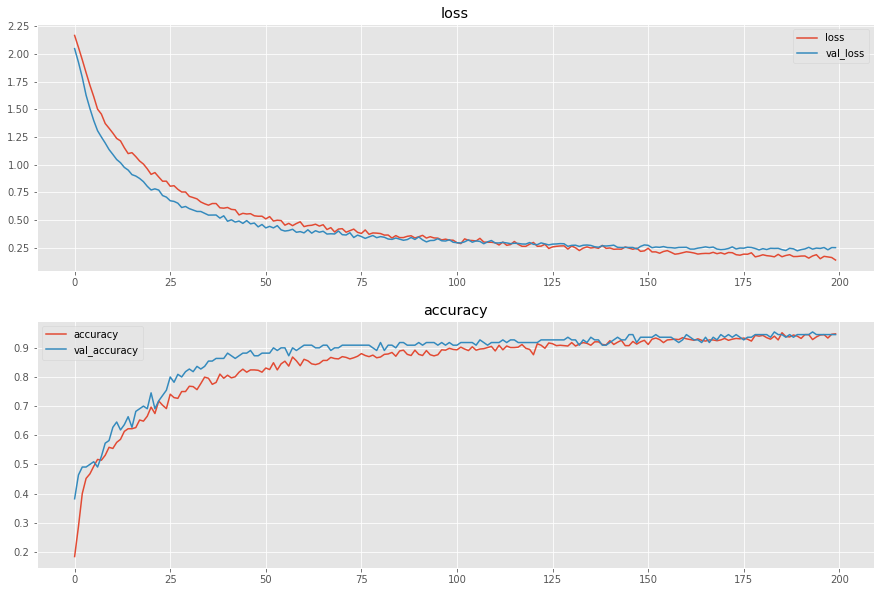

Validation Loss:  0.249643936753273
Validation Accuracy: 94.55%
Test Loss:  0.3181014358997345
Test Accuracy: 90.91%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_1\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_1\assets


Mean time for feature extraction per Sample (Total Samples: 768): 2.395 ms
CV Iteration 2/8


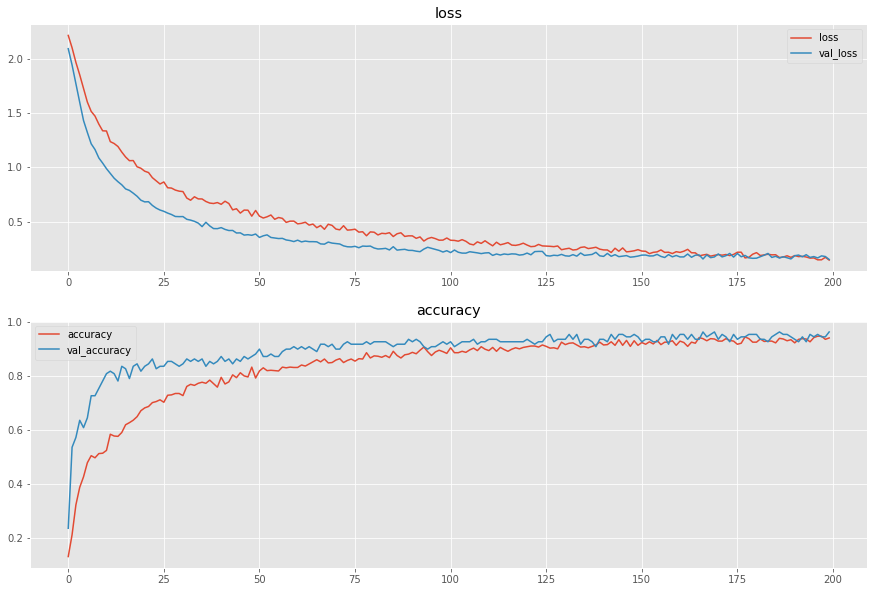

Validation Loss:  0.1520247757434845
Validation Accuracy: 96.36%
Test Loss:  0.32692238688468933
Test Accuracy: 90.91%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_2\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_2\assets


Mean time for feature extraction per Sample (Total Samples: 768): 2.491 ms
CV Iteration 3/8


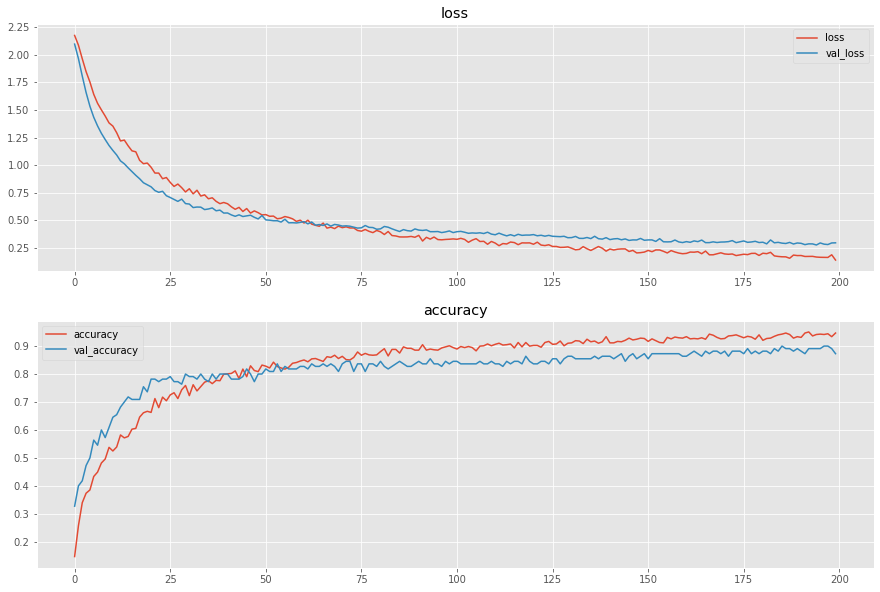

Validation Loss:  0.29682278633117676
Validation Accuracy: 87.27%
Test Loss:  0.3560566306114197
Test Accuracy: 90.00%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_3\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_3\assets


Mean time for feature extraction per Sample (Total Samples: 768): 3.222 ms
CV Iteration 4/8


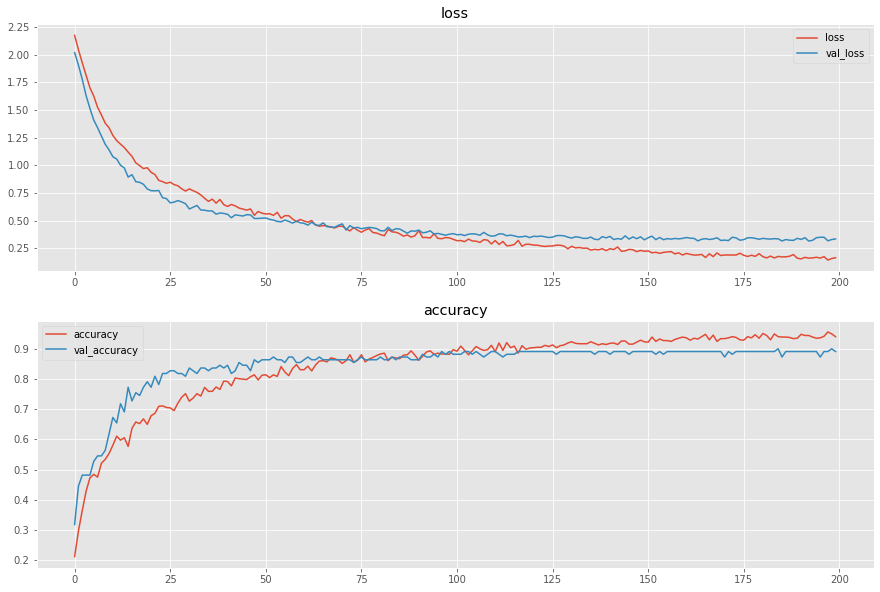

Validation Loss:  0.3352566659450531
Validation Accuracy: 89.09%
Test Loss:  0.33429619669914246
Test Accuracy: 90.45%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_4\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_4\assets


Mean time for feature extraction per Sample (Total Samples: 768): 2.312 ms
CV Iteration 5/8


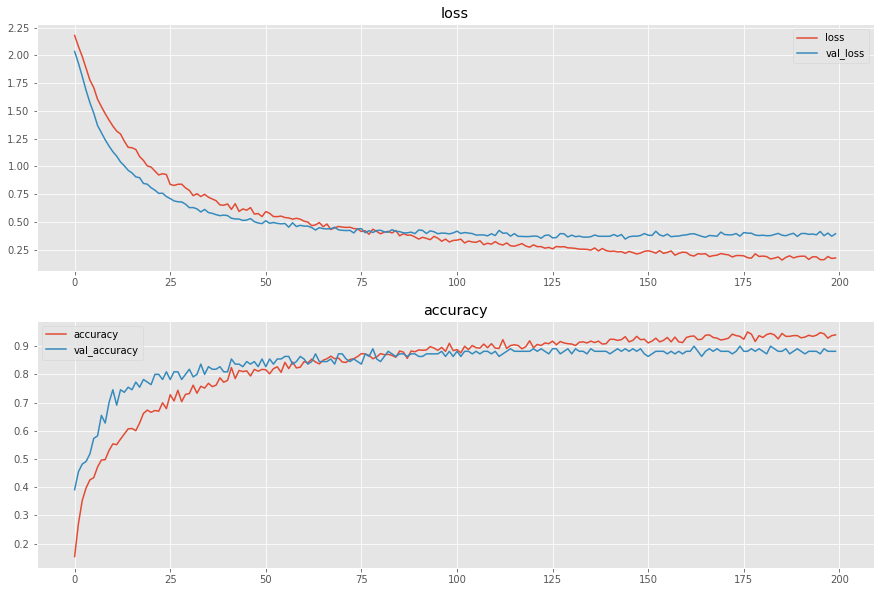

Validation Loss:  0.392241507768631
Validation Accuracy: 88.18%
Test Loss:  0.3401959538459778
Test Accuracy: 89.55%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_5\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_5\assets


Mean time for feature extraction per Sample (Total Samples: 768): 2.331 ms
CV Iteration 6/8


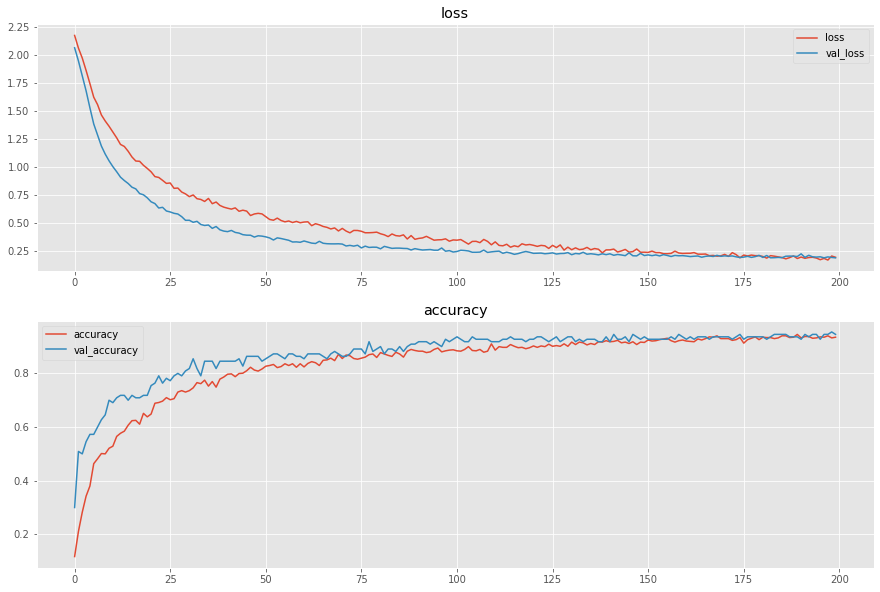

Validation Loss:  0.18488682806491852
Validation Accuracy: 94.55%
Test Loss:  0.317257821559906
Test Accuracy: 90.00%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_6\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_6\assets


Mean time for feature extraction per Sample (Total Samples: 769): 2.309 ms
CV Iteration 7/8


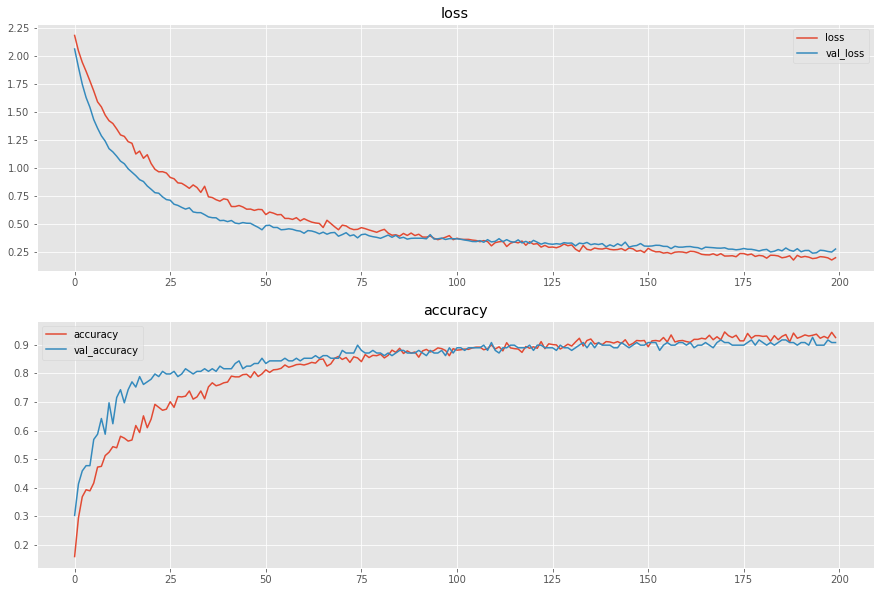

Validation Loss:  0.27552330493927
Validation Accuracy: 90.83%
Test Loss:  0.33375123143196106
Test Accuracy: 89.55%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_7\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_7\assets


Mean time for feature extraction per Sample (Total Samples: 769): 2.516 ms
CV Iteration 8/8


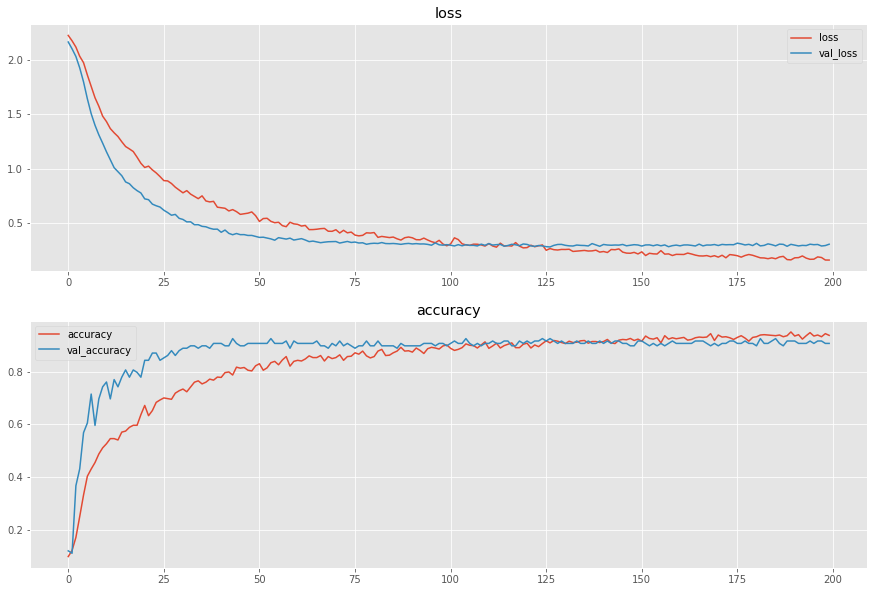

Validation Loss:  0.30807772278785706
Validation Accuracy: 90.83%
Test Loss:  0.2964820861816406
Test Accuracy: 91.36%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_8\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_8\assets


------------------------------------------------------------------------
CV Mean Validation Loss: 0.274309691041708
CV Mean Validation Accuracy: 91.46% sd: 3.12%
CV Mean Test Loss: 0.32788296788930893
CV Mean Test Accuracy: 90.34% sd: 0.63%


In [ ]:
%matplotlib inline
def create_MLP_model(model_input:int, model_output:int):
    model = tf.keras.models.Sequential(name = 'MLP_model') # Define model architecture
    # Input Layer
    model.add(tf.keras.layers.InputLayer(input_shape = (model_input)))
    # Hidden Layers
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))
    # Output Layer
    model.add(tf.keras.layers.Dense(model_output, activation='softmax'))

    # Compile the model
    model.compile(loss=LOSS_FUNCTION,
                optimizer= tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
                metrics=["accuracy"])

    return model

mlp_cv_histories = [] # Save the history of each iteration in cv
mlp_cv_val_accuracy = [] # Save the validation accuracy of each iteration in cv
mlp_cv_val_loss = [] # Save the validation loss of each iteration in cv
mlp_cv_test_accuracy = [] # Save the test accuracy of each iteration in cv
mlp_cv_test_loss = [] # Save the test loss of each iteration in cv

for i, ((X_train_folds, y_train_folds), (X_val_fold, y_val_fold)) in enumerate(cv_train_val_data):
    tf.keras.backend.clear_session() # Reset the session

    # Transforn data using feature extraction from signals for MLP
    mlp_X_train, mlp_y_train = create_data_for_MLP(X_train_folds, y_train_folds, show_feature_extraction_time=True)
    mlp_X_val, mlp_y_val = create_data_for_MLP(X_val_fold, y_val_fold)

    # Apply scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) # StandardScaler()
    mlp_X_train_scaled = scaler.fit_transform(mlp_X_train)
    mlp_X_val_scaled = scaler.transform(mlp_X_val)

    # Define input and outpout shape for the model
    input_size = mlp_X_train_scaled.shape[1]
    output_size = np.max(mlp_y_val) + 1 # Number of categories:9

    # Create & compile model
    model = create_MLP_model(model_input = input_size, model_output = output_size)

    if i == 0: # Plot the model
        print('------------------------------------------------------------------------')
        print("Input Shape: " + str(mlp_X_train_scaled.shape))
        print(model.summary())
        #tf.keras.utils.vis_utils.plot_model(model)
        print('------------------------------------------------------------------------')
    print(f"CV Iteration {i+1}/{len(cv_train_val_data)}")

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(mlp_y_train), y=mlp_y_train)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Fit the model
    history = model.fit(x = mlp_X_train_scaled, y = mlp_y_train,
                        #validation_split = 0.2,
                        validation_data=(mlp_X_val_scaled, mlp_y_val),
                        epochs = EPOCHS, batch_size = BATCH_SIZE,
                        class_weight = class_weights_dict,
                        shuffle = True, verbose = 0)

    plot_history_metrics(history, val_split = True, metrics_to_plot=['loss', 'accuracy', 'val_loss', 'val_accuracy'])
    mlp_cv_histories.append(history.history)

    # Evaluate the model with the validation data for each CV Iteration
    val_scores = model.evaluate(mlp_X_val_scaled, mlp_y_val, verbose=0)
    print("Validation Loss: ",  (val_scores[0]))
    print("Validation Accuracy: %.2f%%" % (val_scores[1]*100))
    mlp_cv_val_loss.append(val_scores[0])
    mlp_cv_val_accuracy.append(val_scores[1]*100)

    # Evaluate the model with the test data for each CV Iteration
    mlp_X_test, mlp_y_test = create_data_for_MLP(X_test, y_test)
    mlp_X_test_scaled = scaler.transform(mlp_X_test)
    test_scores = model.evaluate(mlp_X_test_scaled, mlp_y_test, verbose=0)
    print("Test Loss: ",  (test_scores[0]))
    print("Test Accuracy: %.2f%%" % (test_scores[1]*100))
    mlp_cv_test_loss.append(test_scores[0])
    mlp_cv_test_accuracy.append(test_scores[1]*100)

    mlp_path = "MY_DATA\Keras_Models\MLP"
    model_filename = '\MLP-CV_training_Iteration_' + str(i+1)
    if not os.path.exists(mlp_path): os.makedirs(mlp_path)
    model.save(mlp_path + model_filename)


print('------------------------------------------------------------------------')
print("CV Mean Validation Loss: " +  str(np.mean(mlp_cv_val_loss)))
print("CV Mean Validation Accuracy: %.2f%% sd: %.2f%%" % (np.mean(mlp_cv_val_accuracy), np.std(mlp_cv_val_accuracy)))
print("CV Mean Test Loss: " +  str(np.mean(mlp_cv_test_loss)))
print("CV Mean Test Accuracy: %.2f%% sd: %.2f%%" % (np.mean(mlp_cv_test_accuracy), np.std(mlp_cv_test_accuracy)))


- MLP Prediction

220/220 [==============================] - 1s 2ms/step

Correct predictions: 197/220


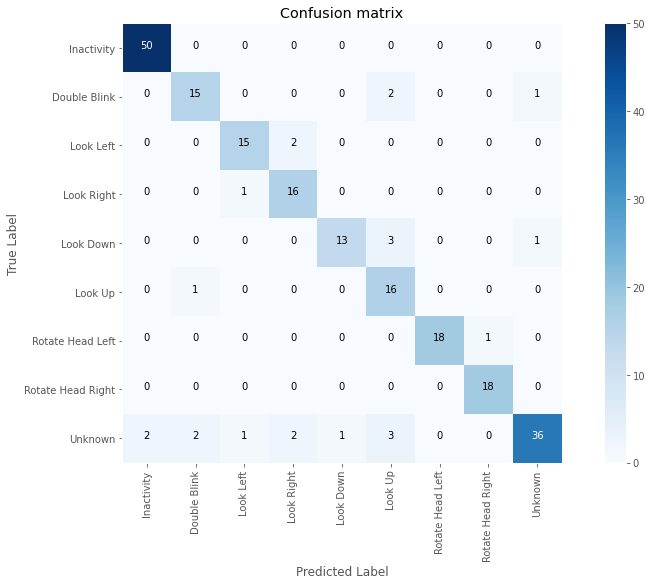

                   precision    recall  f1-score   support

       Inactivity       0.96      1.00      0.98        50
     Double Blink       0.83      0.83      0.83        18
        Look Left       0.88      0.88      0.88        17
       Look Right       0.80      0.94      0.86        17
        Look Down       0.93      0.76      0.84        17
          Look Up       0.67      0.94      0.78        17
 Rotate Head Left       1.00      0.95      0.97        19
Rotate Head Right       0.95      1.00      0.97        18
          Unknown       0.95      0.77      0.85        47

         accuracy                           0.90       220
        macro avg       0.89      0.90      0.89       220
     weighted avg       0.91      0.90      0.90       220

Predictions Threshold (80%) Pass:  187
Average prediction time for a sample in (ms): 53.299713134765625


In [ ]:
loaded_mlp_model = tf.keras.models.load_model("MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_6")

# Make predictions on the test data
mlp_predictions = np.argmax(loaded_mlp_model.predict(mlp_X_test_scaled, batch_size=1), axis=-1)
plot_Confusion_Matrix(mlp_y_test, mlp_predictions, LABEL_NAMES)
print(classification_report(mlp_y_test, mlp_predictions, target_names=LABEL_NAMES))

# Also lets check the inference time for predictions and threshold.

mlp_keep_inference_times = []
threshold = 0.8
threshold_counter = 0

for i in range(mlp_X_test_scaled.shape[0]):
    move_to_predict = np.expand_dims(mlp_X_test_scaled[i], axis=0)
    start_time = time.time()
    mlp_sample_prediction = loaded_mlp_model.predict(move_to_predict, batch_size=1,verbose=0)
    end_time = time.time()
    if (max(mlp_sample_prediction[0]) >= threshold): # Here the [0] is cause we have a nested list as return, but we only check one sample per time
        threshold_counter += 1
    mlp_keep_inference_times.append(end_time - start_time)

print('Predictions Threshold (80%) Pass: ',threshold_counter)
print("Average prediction time for a sample in (ms):", 1000*np.mean(mlp_keep_inference_times))

## LSTM Model

------------------------------------------------------------------------
Input Shape: (768, 192, 6)
Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 192, 128)          69120     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                 297       
                      

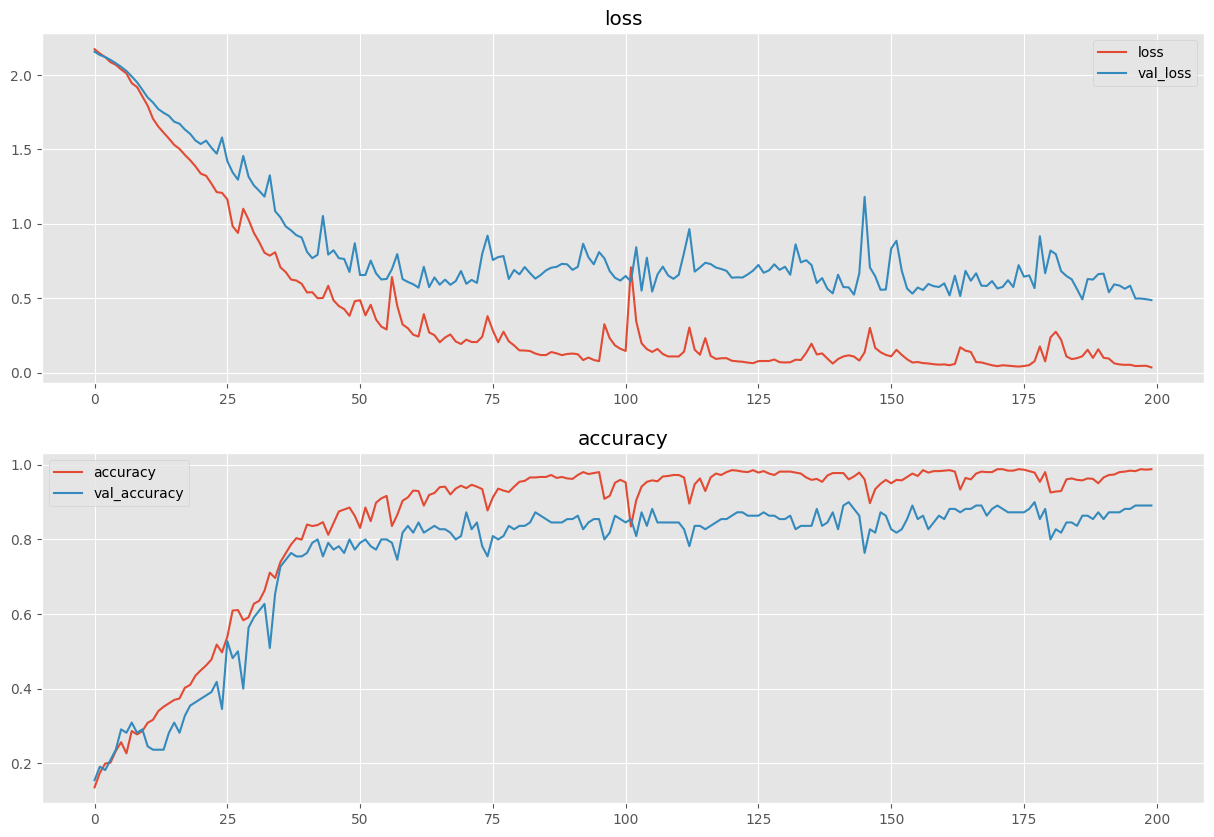

Validation Loss:  0.48706546425819397
Validation Accuracy: 89.09%
Test Loss:  0.5305386185646057
Test Accuracy: 89.09%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_1\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_1\assets


CV Iteration 2/8


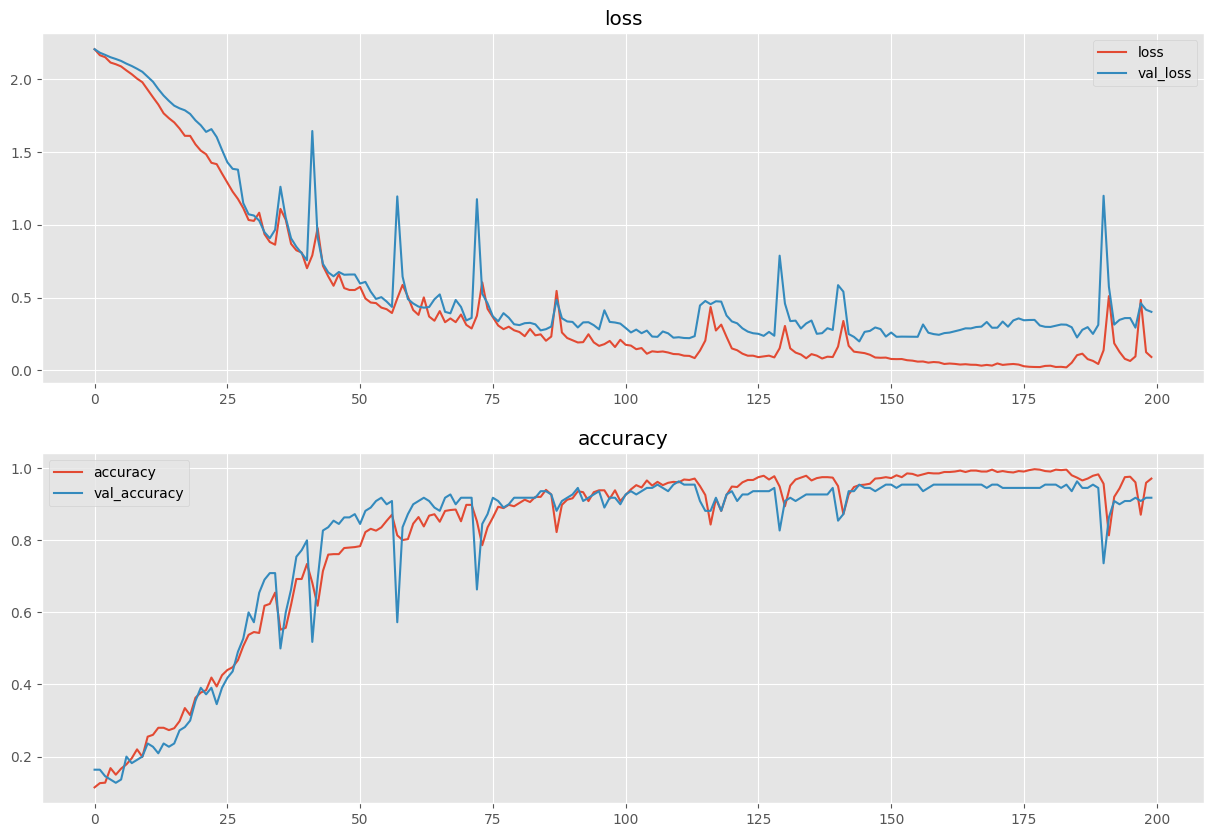

Validation Loss:  0.4019283652305603
Validation Accuracy: 91.82%
Test Loss:  0.3496452271938324
Test Accuracy: 91.36%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_2\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_2\assets


CV Iteration 3/8


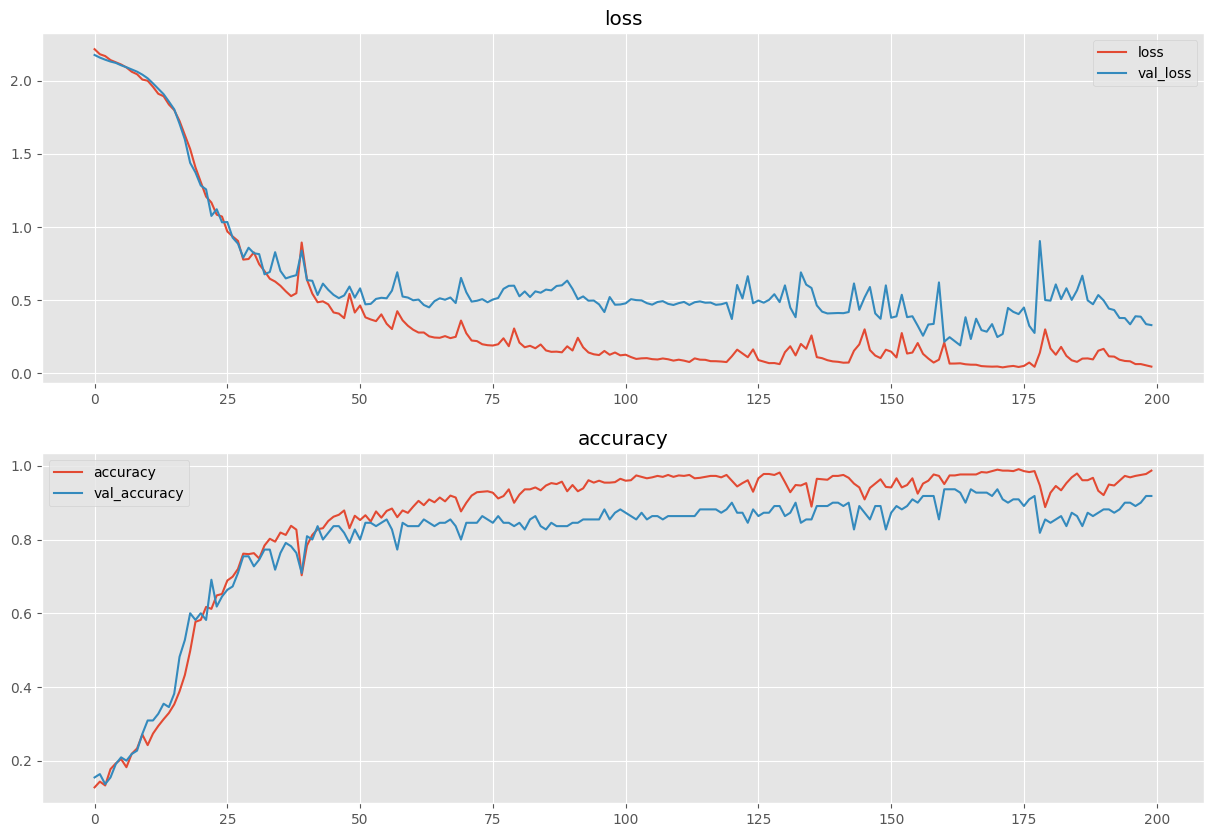

Validation Loss:  0.3291706144809723
Validation Accuracy: 91.82%
Test Loss:  0.2718884348869324
Test Accuracy: 91.36%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_3\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_3\assets


CV Iteration 4/8


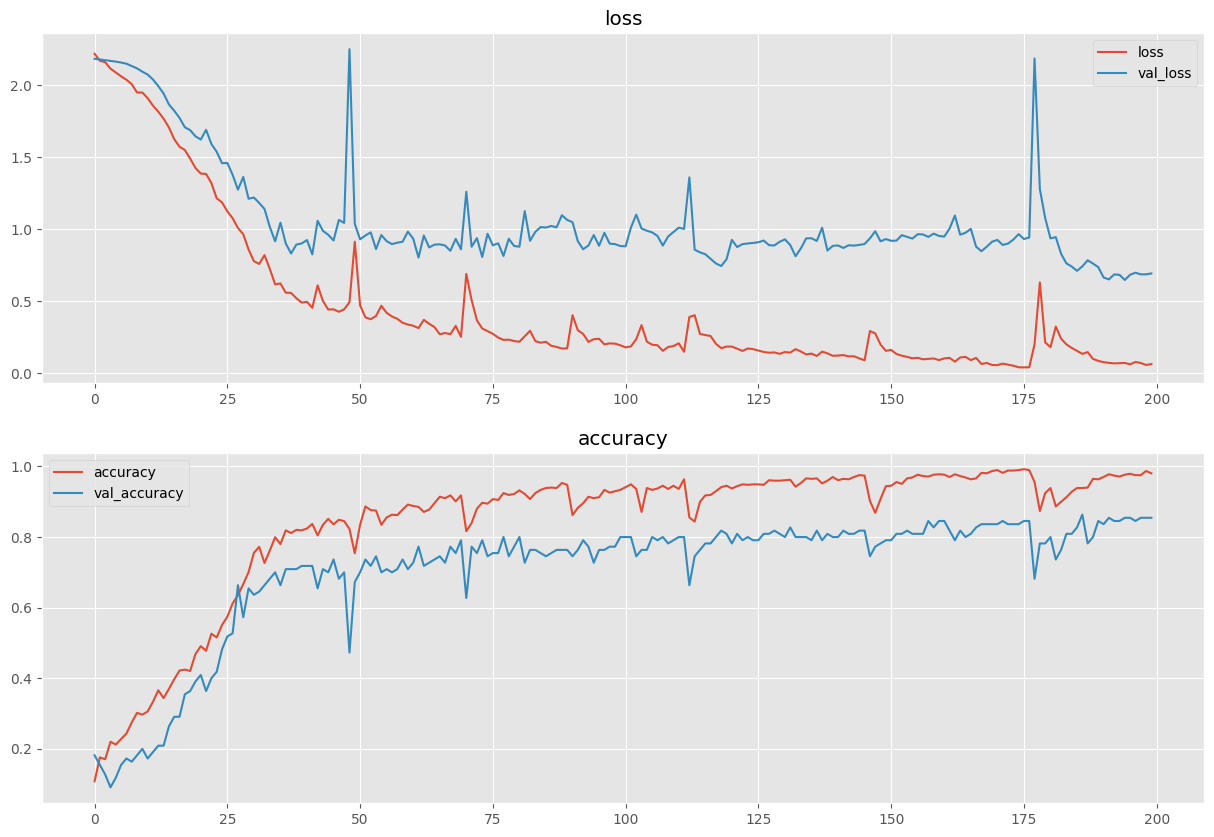

Validation Loss:  0.6932409405708313
Validation Accuracy: 85.45%
Test Loss:  0.41509687900543213
Test Accuracy: 90.45%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_4\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_4\assets


CV Iteration 5/8


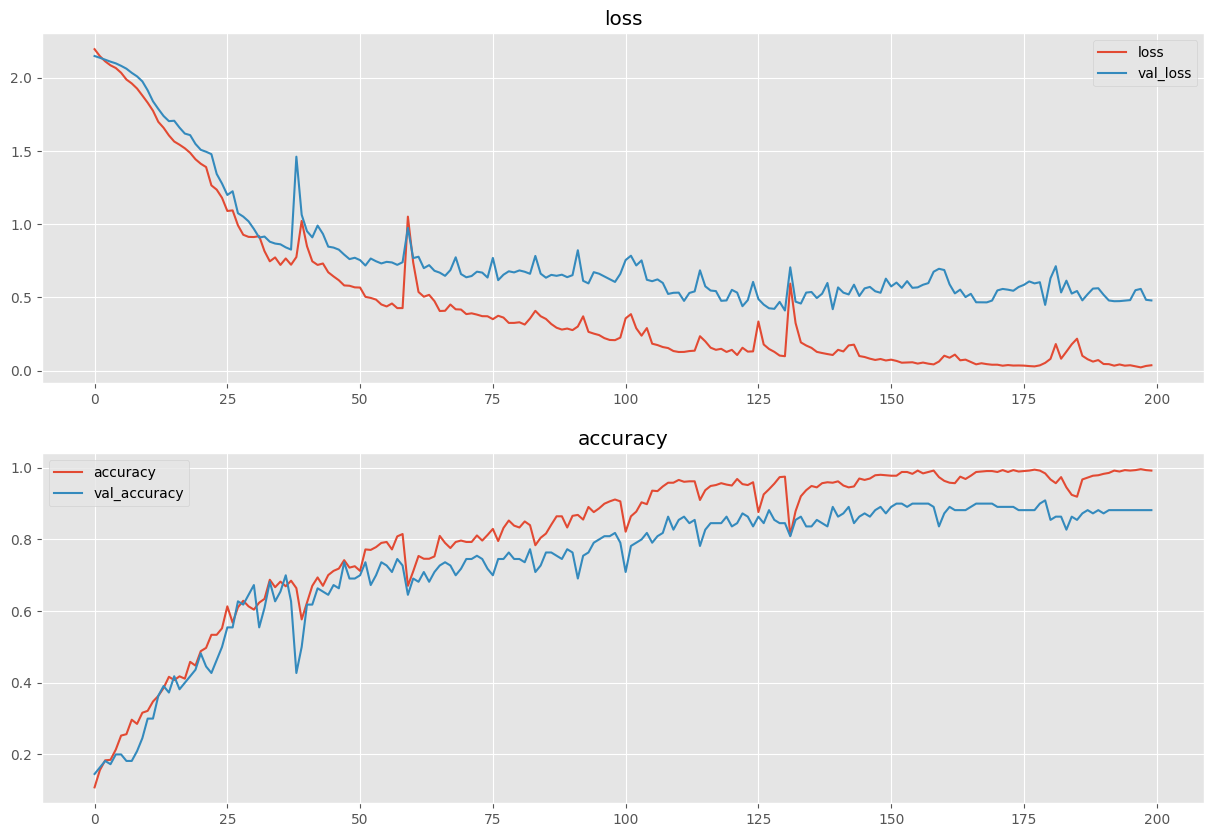

Validation Loss:  0.4791814684867859
Validation Accuracy: 88.18%
Test Loss:  0.4657089114189148
Test Accuracy: 90.91%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_5\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_5\assets


CV Iteration 6/8


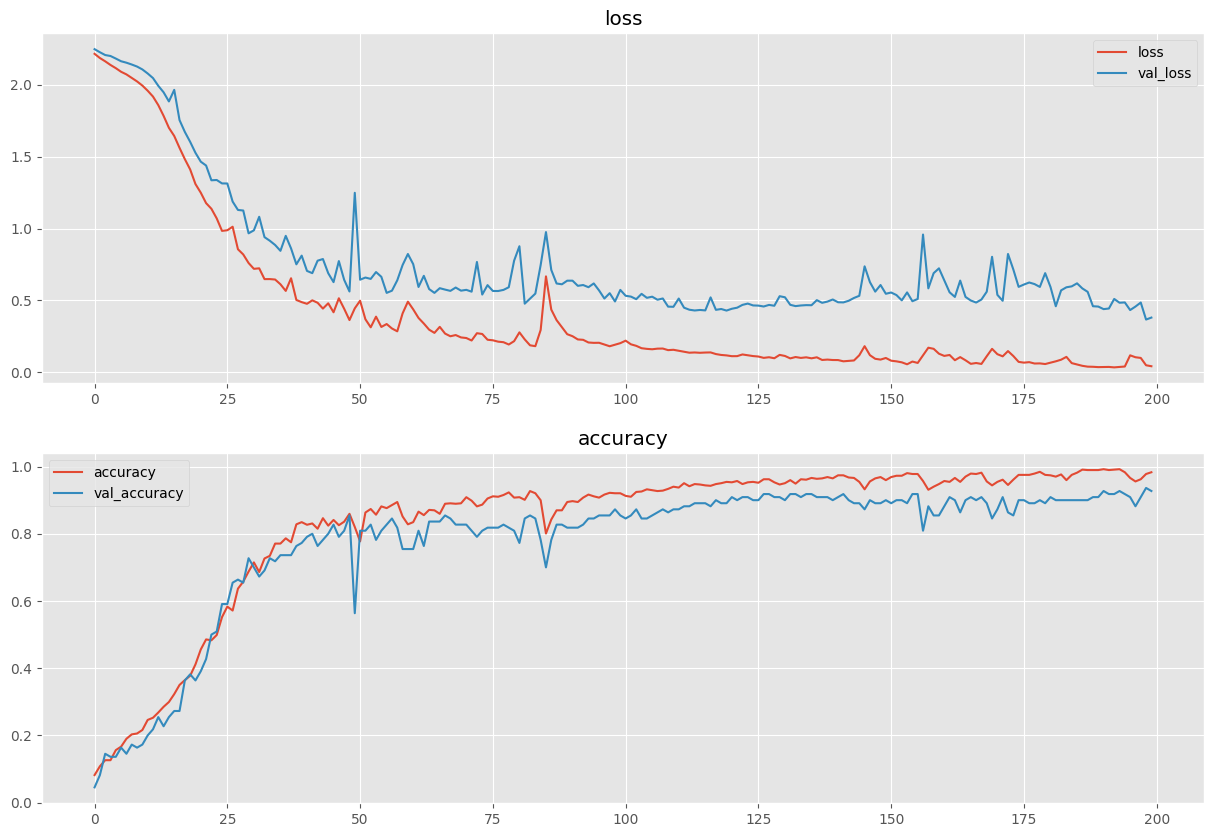

Validation Loss:  0.3809109628200531
Validation Accuracy: 92.73%
Test Loss:  0.8449960947036743
Test Accuracy: 84.09%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_6\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_6\assets


CV Iteration 7/8


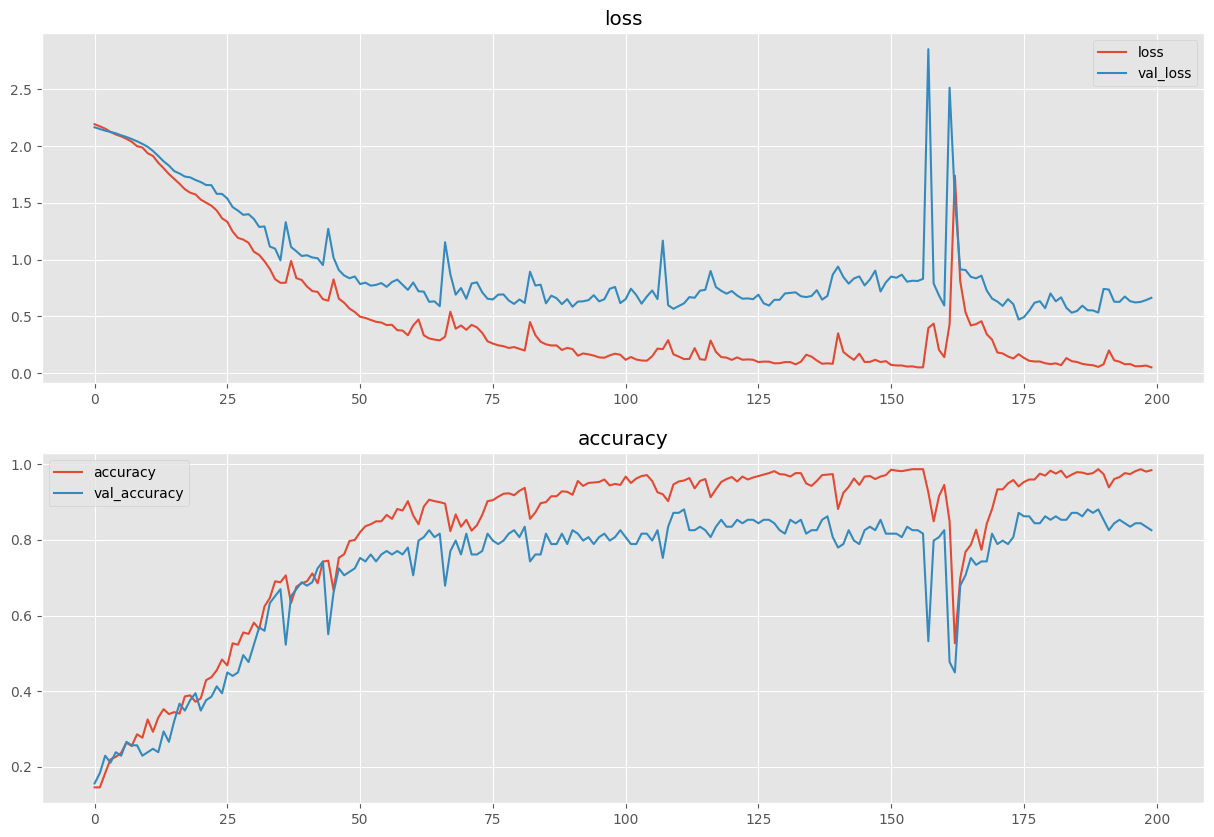

Validation Loss:  0.6639646887779236
Validation Accuracy: 82.57%
Test Loss:  0.5873496532440186
Test Accuracy: 85.45%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_7\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_7\assets


CV Iteration 8/8


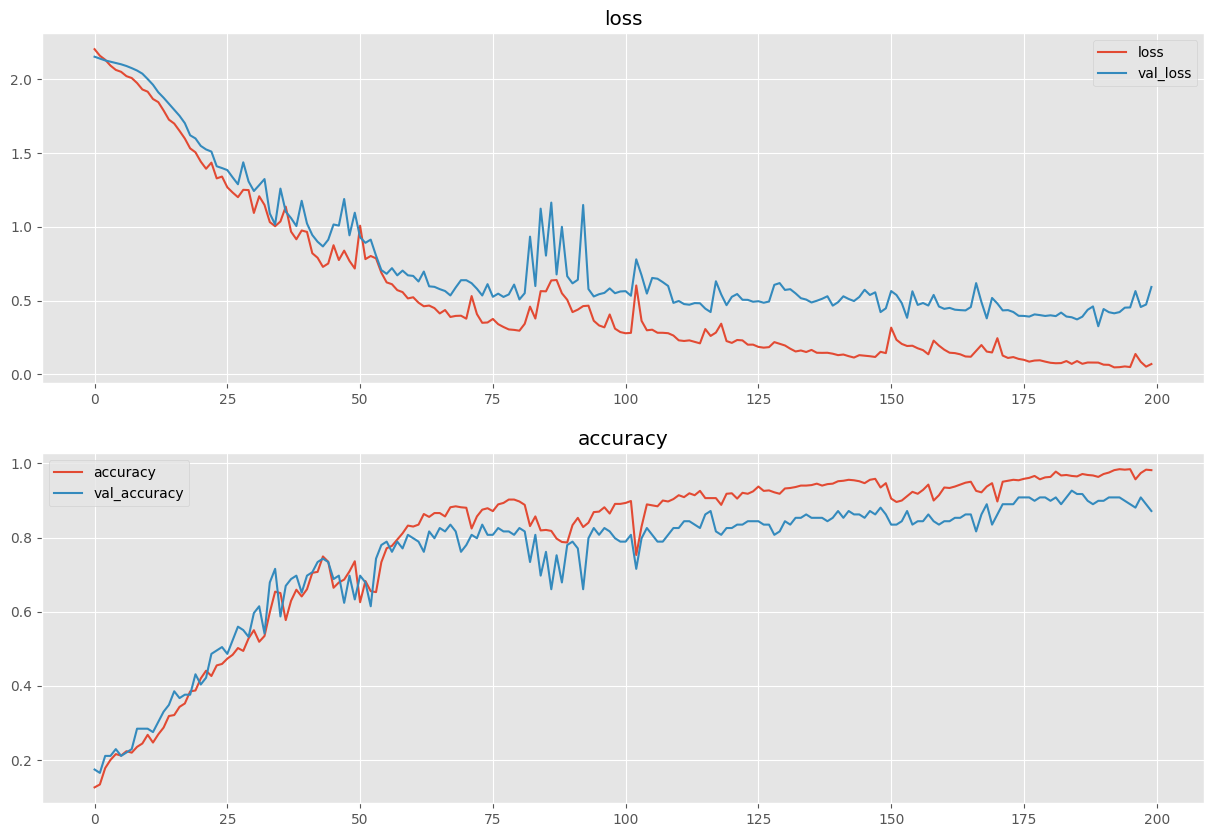

Validation Loss:  0.5926579236984253
Validation Accuracy: 87.16%
Test Loss:  0.5573307275772095
Test Accuracy: 87.27%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_8\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_8\assets


------------------------------------------------------------------------
CV Mean Validation Loss: 0.5035150535404682
CV Mean Validation Accuracy: 88.60% sd: 3.29%
CV Mean Test Loss: 0.5028193183243275
CV Mean Test Accuracy: 88.75% sd: 2.65%


In [ ]:
%matplotlib inline

def create_LSTM_model(model_input:tuple,model_output:int):

    model = tf.keras.models.Sequential(name='LSTM_model') # Define model architecture
    # Input Layer
    model.add(tf.keras.layers.InputLayer(input_shape = model_input))

    # Hidden Layers (Stacked LSTMs)
    model.add(tf.keras.layers.LSTM(128, return_sequences=True, stateful=False))
    model.add(tf.keras.layers.LSTM(64, return_sequences=False, stateful=False))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))
    # Add 1 Dense Layer
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))
    # Output Layer
    model.add(tf.keras.layers.Dense(model_output, activation = 'softmax'))

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
                metrics=["accuracy"])
    return model

def convert_X_data_to_3D_array(df_list):
    num_samples = len(df_list)
    timesteps, channels = df_list[0].shape
    result_array = np.zeros((num_samples, timesteps, channels))
    for i, df in enumerate(df_list): result_array[i] = df.to_numpy()
    return result_array

lstm_cv_histories = [] # Save the history of each iteration in cv
lstm_cv_val_accuracy = [] # Save the validation accuracy of each iteration in cv
lstm_cv_val_loss = [] # Save the validation loss of each iteration in cv
lstm_cv_test_accuracy = [] # Save the test accuracy of each iteration in cv
lstm_cv_test_loss = [] # Save the test loss of each iteration in cv

for i, ((X_train_folds, y_train_folds), (X_val_fold, y_val_fold)) in enumerate(cv_train_val_data):
    tf.keras.backend.clear_session() # Reset the session

    # Convert X data to 3D numpy arrays (samples,timesteps, channels) and labels to 1D numpy arrays
    lstm_X_train, lstm_y_train = convert_X_data_to_3D_array(X_train_folds), np.array(y_train_folds)
    lstm_X_val, lstm_y_val = convert_X_data_to_3D_array(X_val_fold), np.array(y_val_fold)

    # Define input and outpout shape for the model
    input_size = (lstm_X_train.shape[1], lstm_X_train.shape[2])
    output_size = np.max(lstm_y_val) + 1 # Number of categories:9

    # Create & compile model
    model = create_LSTM_model(model_input = input_size, model_output = output_size)

    if i == 0: # Plot the model
        print('------------------------------------------------------------------------')
        print("Input Shape: " + str(lstm_X_train.shape))
        print(model.summary())
        #tf.keras.utils.vis_utils.plot_model(model)
        print('------------------------------------------------------------------------')
    print(f"CV Iteration {i+1}/{len(cv_train_val_data)}")

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(lstm_y_train), y=lstm_y_train)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Fit the model
    lstm_history = model.fit(x = lstm_X_train, y = lstm_y_train,
                        validation_data=(lstm_X_val, lstm_y_val),
                        epochs = EPOCHS, batch_size = BATCH_SIZE,
                        class_weight = class_weights_dict,
                        shuffle = True, verbose = 0)

    plot_history_metrics(lstm_history, val_split = True, metrics_to_plot=['loss', 'accuracy', 'val_loss', 'val_accuracy'])
    lstm_cv_histories.append(lstm_history.history)

    # Evaluate the model with the validation data for each CV Iteration
    lstm_val_scores = model.evaluate(lstm_X_val, lstm_y_val, verbose=0)
    print("Validation Loss: ",  (lstm_val_scores[0]))
    print("Validation Accuracy: %.2f%%" % (lstm_val_scores[1]*100))
    lstm_cv_val_loss.append(lstm_val_scores[0])
    lstm_cv_val_accuracy.append(lstm_val_scores[1]*100)

    # Evaluate the model with the test data for each CV Iteration
    lstm_X_test, lstm_y_test = convert_X_data_to_3D_array(X_test), np.array(y_test)
    lstm_test_scores = model.evaluate(lstm_X_test, lstm_y_test, verbose=0)
    print("Test Loss: ",  (lstm_test_scores[0]))
    print("Test Accuracy: %.2f%%" % (lstm_test_scores[1]*100))
    lstm_cv_test_loss.append(lstm_test_scores[0])
    lstm_cv_test_accuracy.append(lstm_test_scores[1]*100)

    lstm_path = "MY_DATA\Keras_Models\LSTM"
    model_filename = '\LSTM-CV_training_Iteration_' + str(i+1)
    if not os.path.exists(lstm_path): os.makedirs(lstm_path)
    model.save(lstm_path + model_filename)


print('------------------------------------------------------------------------')
print("CV Mean Validation Loss: " +  str(np.mean(lstm_cv_val_loss)))
print("CV Mean Validation Accuracy: %.2f%% sd: %.2f%%" % (np.mean(lstm_cv_val_accuracy), np.std(lstm_cv_val_accuracy)))
print("CV Mean Test Loss: " +  str(np.mean(lstm_cv_test_loss)))
print("CV Mean Test Accuracy: %.2f%% sd: %.2f%%" % (np.mean(lstm_cv_test_accuracy), np.std(lstm_cv_test_accuracy)))


- LSTM Predictions

220/220 [==============================] - 4s 15ms/step

Correct predictions: 196/220


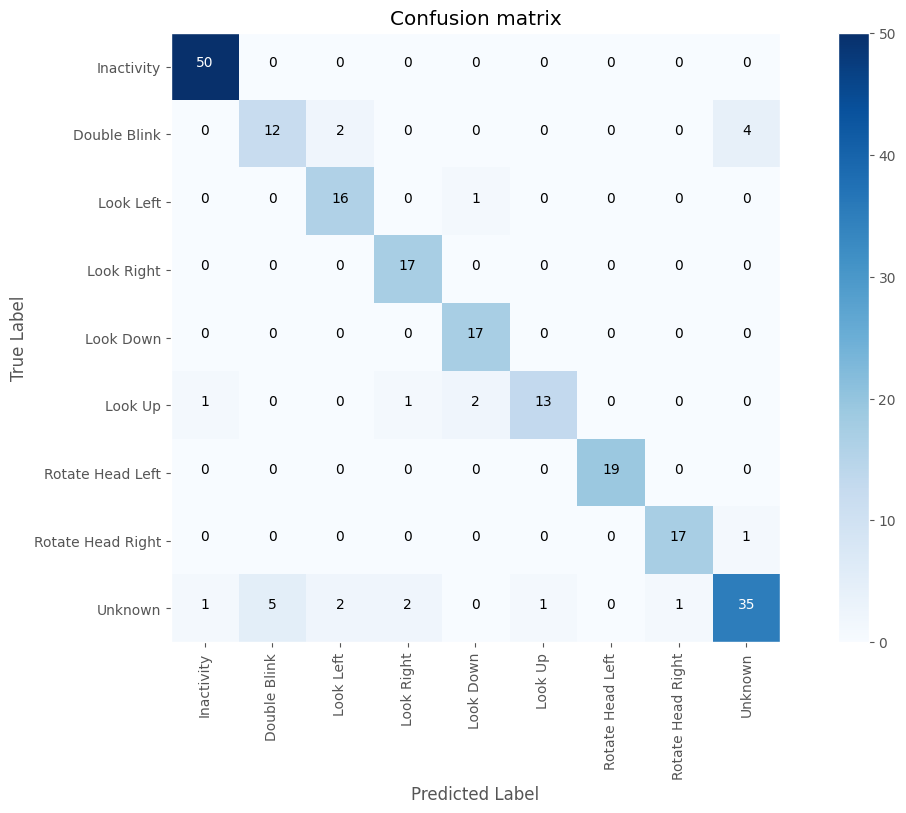

                   precision    recall  f1-score   support

       Inactivity       0.96      1.00      0.98        50
     Double Blink       0.71      0.67      0.69        18
        Look Left       0.80      0.94      0.86        17
       Look Right       0.85      1.00      0.92        17
        Look Down       0.85      1.00      0.92        17
          Look Up       0.93      0.76      0.84        17
 Rotate Head Left       1.00      1.00      1.00        19
Rotate Head Right       0.94      0.94      0.94        18
          Unknown       0.88      0.74      0.80        47

         accuracy                           0.89       220
        macro avg       0.88      0.90      0.88       220
     weighted avg       0.89      0.89      0.89       220

Predictions Threshold (80%) Pass:  205
Average prediction time for a sample in (ms): 53.79663922569968


In [ ]:
loaded_lstm_model = tf.keras.models.load_model("MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_1")

# Make predictions on the test data
lstm_predictions = np.argmax(loaded_lstm_model.predict(lstm_X_test, batch_size=1), axis=-1)
plot_Confusion_Matrix(lstm_y_test, lstm_predictions, LABEL_NAMES)
print(classification_report(lstm_y_test, lstm_predictions, target_names=LABEL_NAMES))

# Also lets check the inference time for predictions and threshold.

lstm_keep_inference_times = []
threshold = 0.8
threshold_counter = 0

for i in range(lstm_X_test.shape[0]):
    move_to_predict = np.expand_dims(lstm_X_test[i], axis=0)
    start_time = time.time()
    lstm_sample_prediction = loaded_lstm_model.predict(move_to_predict, batch_size=1,verbose=0)
    end_time = time.time()
    if (max(lstm_sample_prediction[0]) >= threshold): # Here the [0] is cause we have a nested list as return, but we only check one sample per time
        threshold_counter += 1
    lstm_keep_inference_times.append(end_time - start_time)

print('Predictions Threshold (80%) Pass: ',threshold_counter)
print("Average prediction time for a sample in (ms):", 1000*np.mean(lstm_keep_inference_times))

## CNN Model

------------------------------------------------------------------------
Input Shape: (768, 192, 6)
Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 128)           15488     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                       

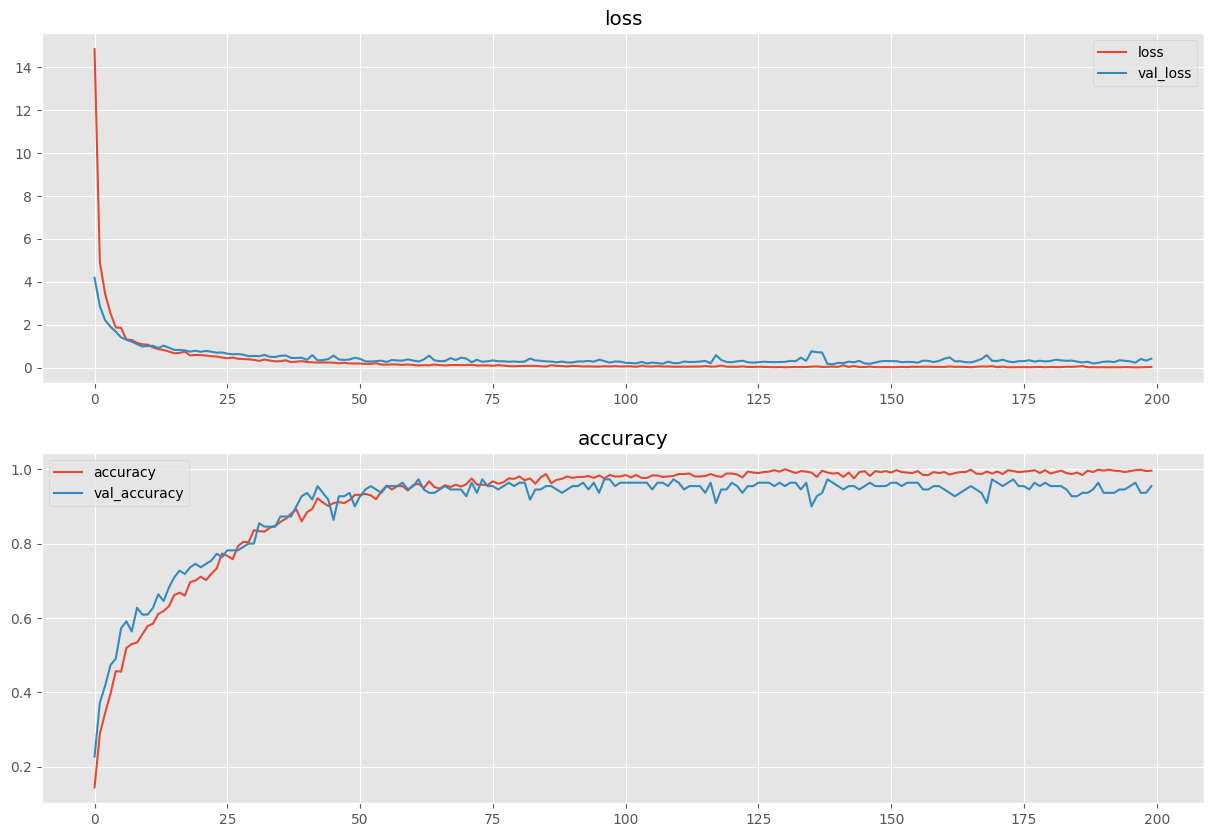

Validation Loss:  0.41116684675216675
Validation Accuracy: 95.45%
Test Loss:  0.5038771629333496
Test Accuracy: 92.73%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_1\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_1\assets


CV Iteration 2/8


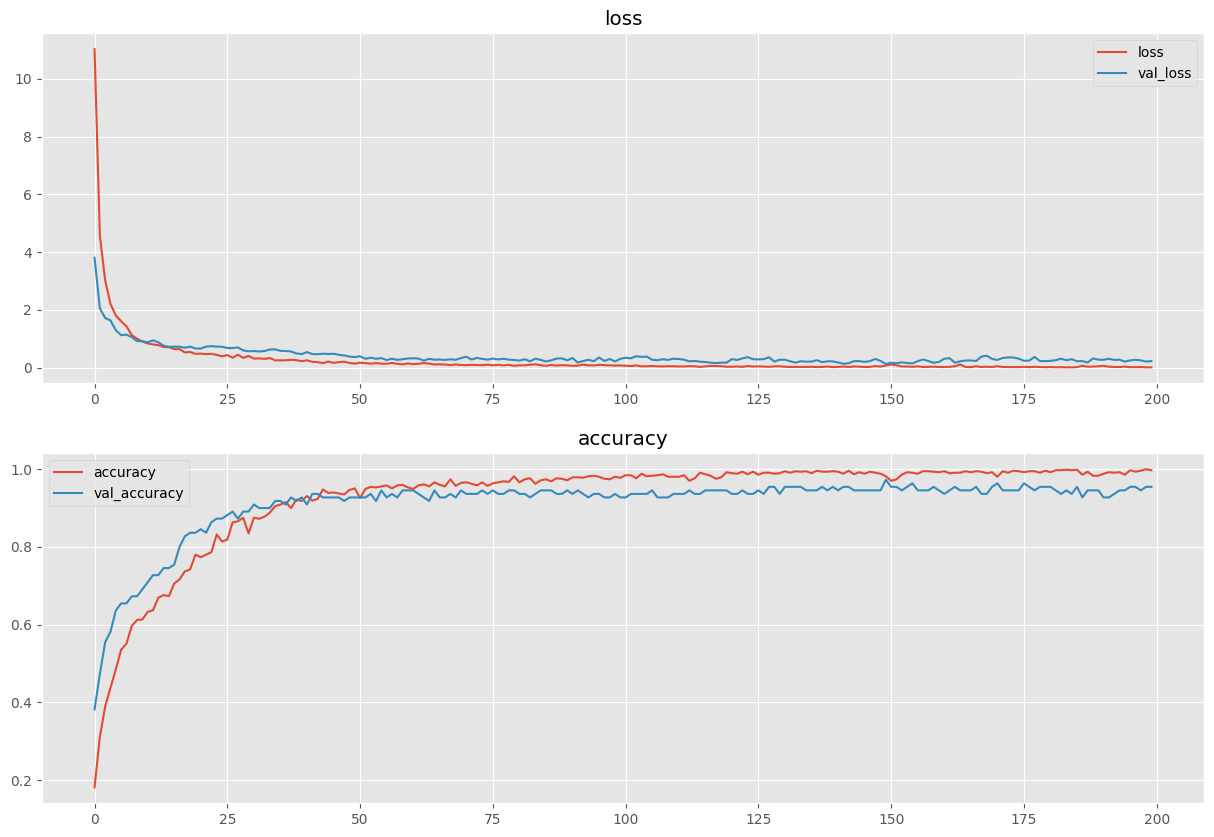

Validation Loss:  0.22118620574474335
Validation Accuracy: 95.45%
Test Loss:  0.5228187441825867
Test Accuracy: 93.64%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_2\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_2\assets


CV Iteration 3/8


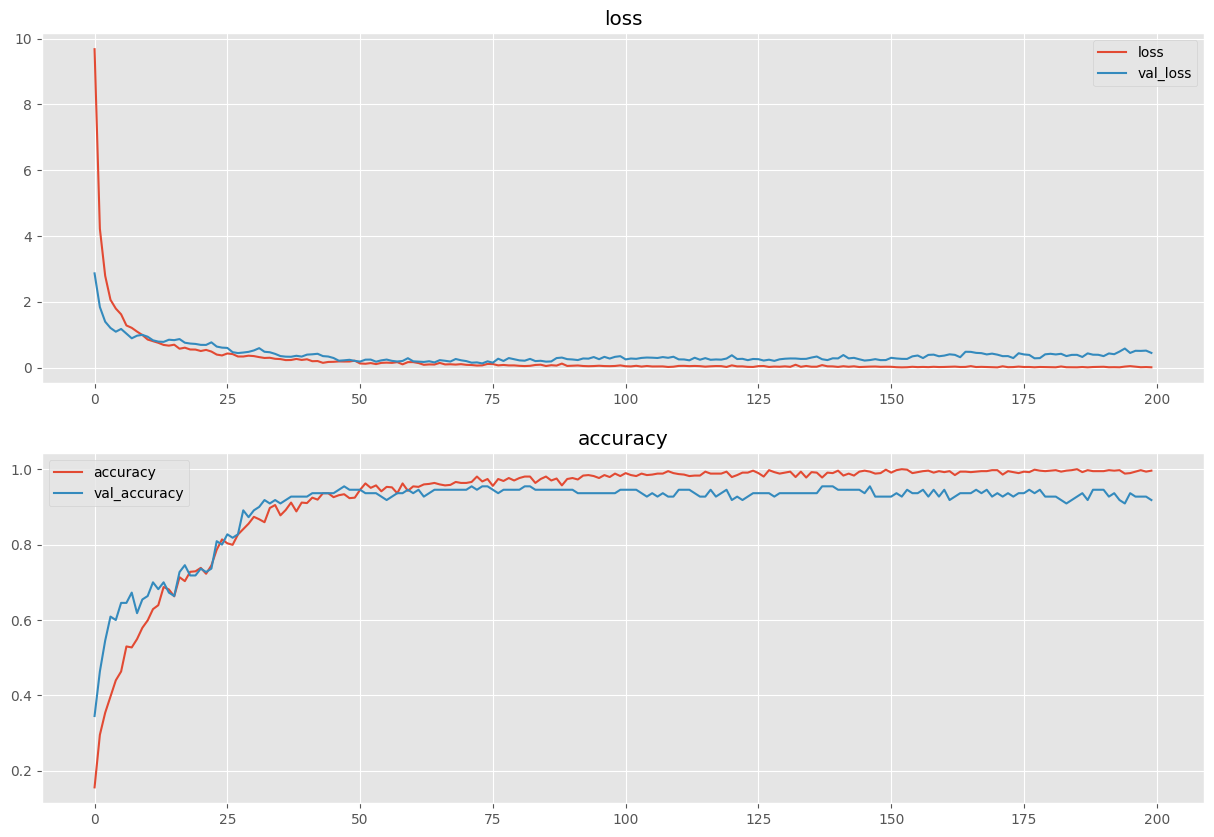

Validation Loss:  0.44580599665641785
Validation Accuracy: 91.82%
Test Loss:  0.4996708333492279
Test Accuracy: 93.18%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_3\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_3\assets


CV Iteration 4/8


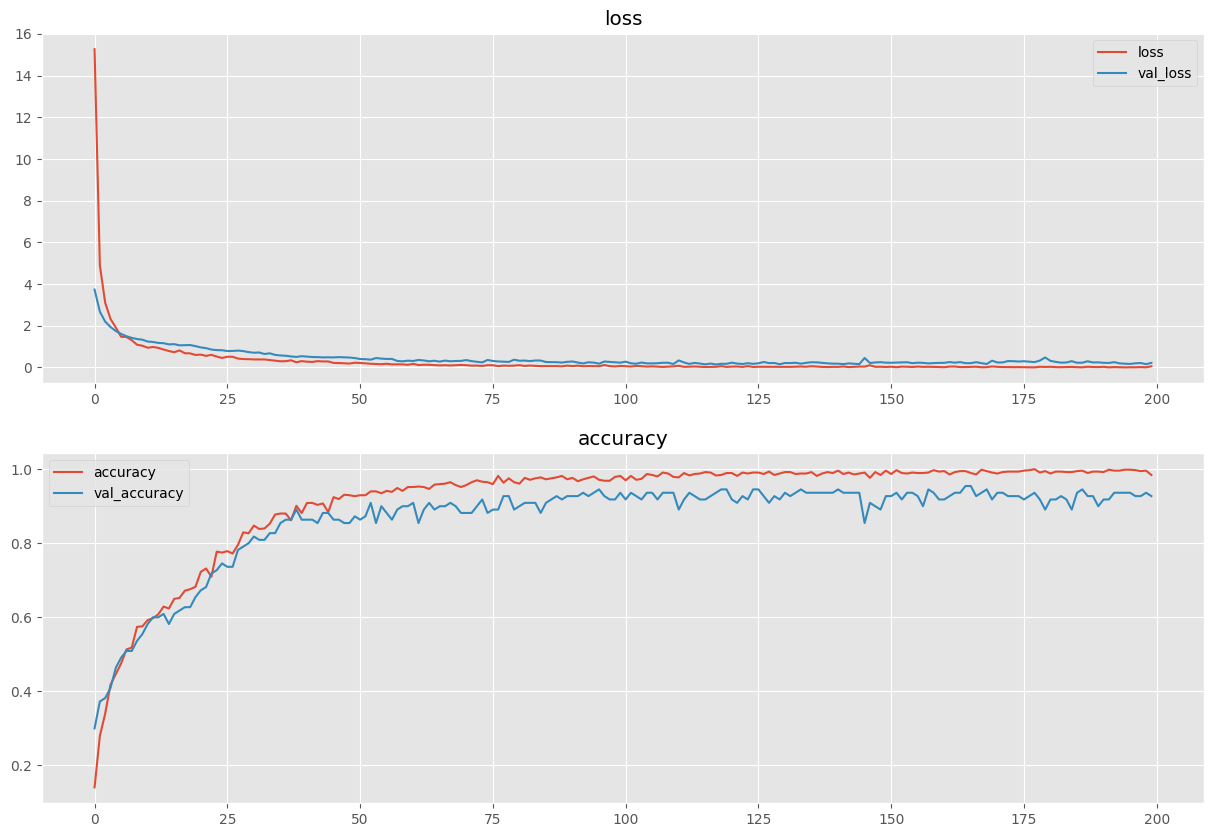

Validation Loss:  0.21946579217910767
Validation Accuracy: 92.73%
Test Loss:  0.3390046954154968
Test Accuracy: 94.09%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_4\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_4\assets


CV Iteration 5/8


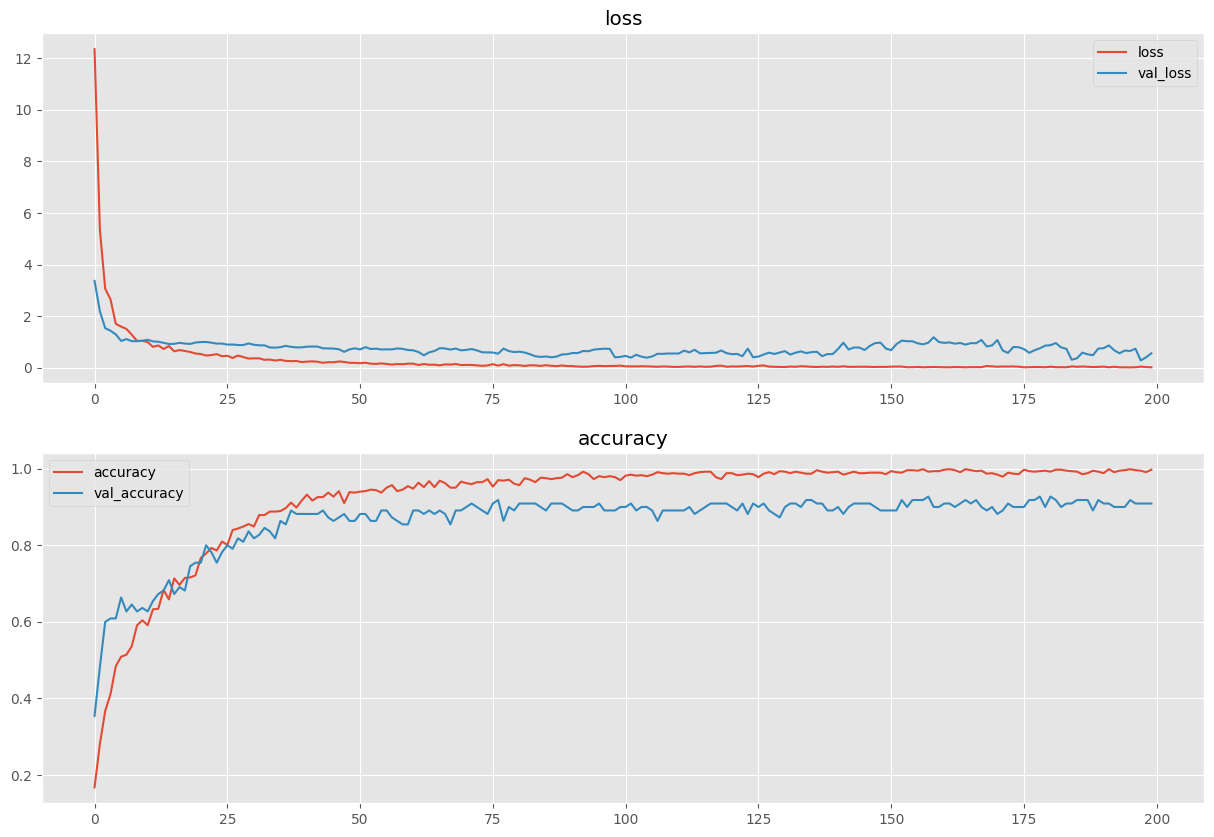

Validation Loss:  0.5527556538581848
Validation Accuracy: 90.91%
Test Loss:  0.6604758501052856
Test Accuracy: 93.18%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_5\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_5\assets


CV Iteration 6/8


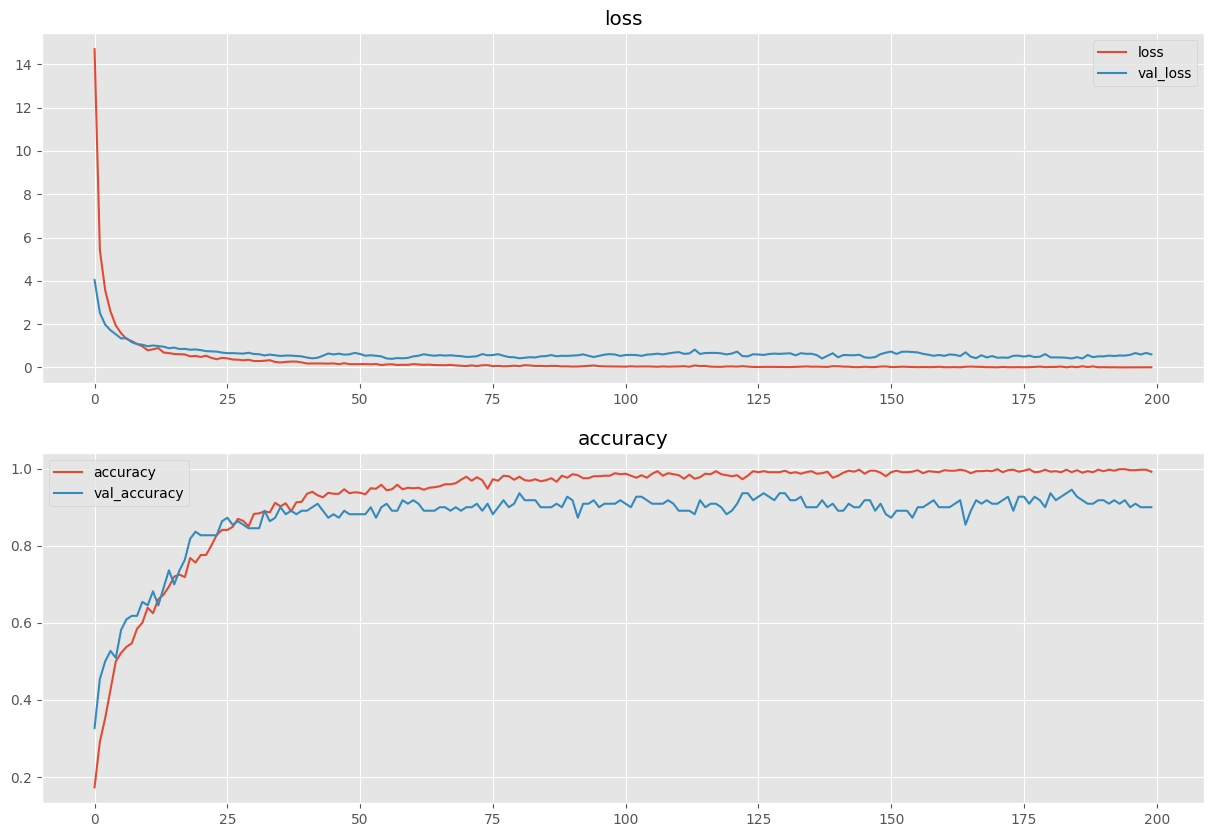

Validation Loss:  0.6044803261756897
Validation Accuracy: 90.00%
Test Loss:  0.4255310297012329
Test Accuracy: 93.18%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_6\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_6\assets


CV Iteration 7/8


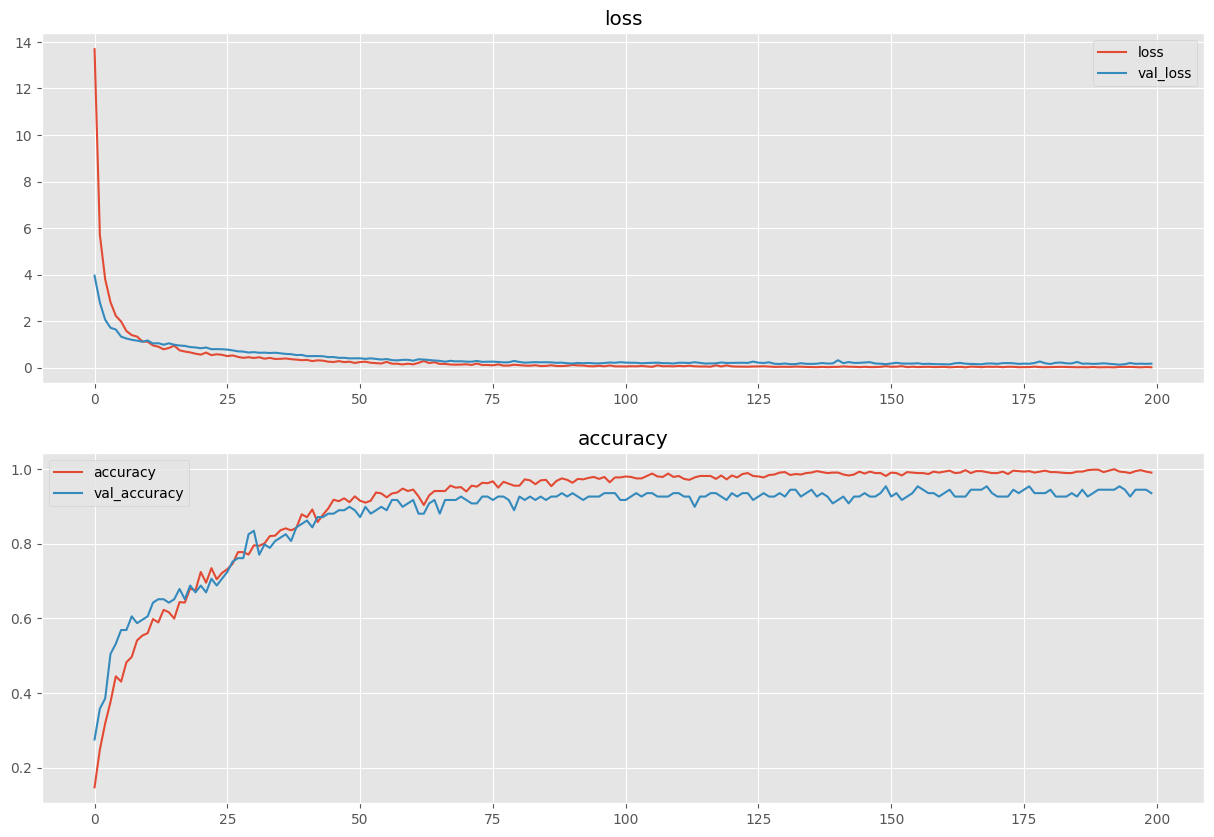

Validation Loss:  0.1675114631652832
Validation Accuracy: 93.58%
Test Loss:  0.2888863682746887
Test Accuracy: 94.55%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_7\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_7\assets


CV Iteration 8/8


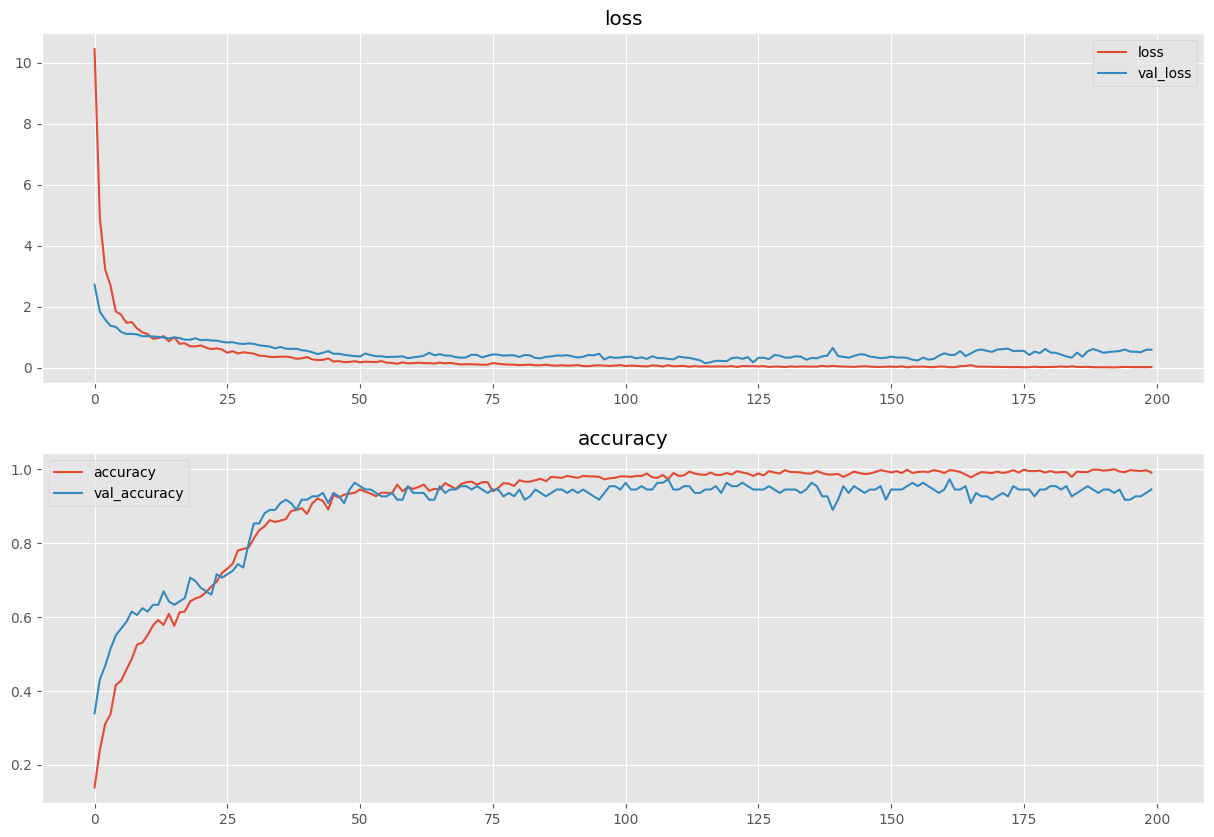

Validation Loss:  0.5858554244041443
Validation Accuracy: 94.50%
Test Loss:  0.43179386854171753
Test Accuracy: 95.45%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_8\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_8\assets


------------------------------------------------------------------------
CV Mean Validation Loss: 0.4010284636169672
CV Mean Validation Accuracy: 93.05% sd: 1.92%
CV Mean Test Loss: 0.5028193183243275
CV Mean Test Accuracy: 93.75% sd: 0.84%


In [ ]:
def create_CNN_model(model_input:tuple,model_output:int):
    model = tf.keras.models.Sequential(name='CNN_model') # Define model architecture
    # Input Layer
    model.add(tf.keras.layers.InputLayer(input_shape = model_input))

    # Add CNN and Pooling layers
    model.add(tf.keras.layers.Conv1D(filters = 128, kernel_size = 20, strides = 4, activation='relu',padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, activation='relu',padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size = 4, strides=2))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))
    model.add(tf.keras.layers.Flatten())

    # add 1- dense layer
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))

    model.add(tf.keras.layers.Dense(model_output, activation = 'softmax'))

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
                metrics=["accuracy"])
    return model

def convert_X_data_to_3D_array(df_list):
    num_samples = len(df_list)
    timesteps, channels = df_list[0].shape
    result_array = np.zeros((num_samples, timesteps, channels))
    for i, df in enumerate(df_list): result_array[i] = df.to_numpy()
    return result_array

cnn_cv_histories = [] # Save the history of each iteration in cv
cnn_cv_val_accuracy = [] # Save the validation accuracy of each iteration in cv
cnn_cv_val_loss = [] # Save the validation loss of each iteration in cv
cnn_cv_test_accuracy = [] # Save the test accuracy of each iteration in cv
cnn_cv_test_loss = [] # Save the test loss of each iteration in cv

for i, ((X_train_folds, y_train_folds), (X_val_fold, y_val_fold)) in enumerate(cv_train_val_data):
    tf.keras.backend.clear_session() # Reset the session

    # Convert X data to 3D numpy arrays (samples,timesteps, channels) and labels to 1D numpy arrays
    cnn_X_train, cnn_y_train = convert_X_data_to_3D_array(X_train_folds), np.array(y_train_folds)
    cnn_X_val, cnn_y_val = convert_X_data_to_3D_array(X_val_fold), np.array(y_val_fold)

    # Define input and outpout shape for the model
    input_size = (cnn_X_train.shape[1], cnn_X_train.shape[2])
    output_size = np.max(cnn_y_val) + 1 # Number of categories:9

    # Create & compile model
    model = create_CNN_model(model_input = input_size, model_output = output_size)

    if i == 0: # Plot the model
        print('------------------------------------------------------------------------')
        print("Input Shape: " + str(cnn_X_train.shape))
        print(model.summary())
        #tf.keras.utils.vis_utils.plot_model(model)
        print('------------------------------------------------------------------------')
    print(f"CV Iteration {i+1}/{len(cv_train_val_data)}")

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(cnn_y_train), y=cnn_y_train)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Fit the model
    cnn_history = model.fit(x = cnn_X_train, y = cnn_y_train,
                        validation_data=(cnn_X_val, cnn_y_val),
                        epochs = EPOCHS, batch_size = BATCH_SIZE,
                        class_weight = class_weights_dict,
                        shuffle = True, verbose = 0)

    plot_history_metrics(cnn_history, val_split = True, metrics_to_plot=['loss', 'accuracy', 'val_loss', 'val_accuracy'])
    cnn_cv_histories.append(cnn_history.history)

    # Evaluate the model with the validation data for each CV Iteration
    cnn_val_scores = model.evaluate(cnn_X_val, cnn_y_val, verbose=0)
    print("Validation Loss: ",  (cnn_val_scores[0]))
    print("Validation Accuracy: %.2f%%" % (cnn_val_scores[1]*100))
    cnn_cv_val_loss.append(cnn_val_scores[0])
    cnn_cv_val_accuracy.append(cnn_val_scores[1]*100)

    # Evaluate the model with the test data for each CV Iteration
    cnn_X_test, cnn_y_test = convert_X_data_to_3D_array(X_test), np.array(y_test)
    cnn_test_scores = model.evaluate(cnn_X_test, cnn_y_test, verbose=0)
    print("Test Loss: ",  (cnn_test_scores[0]))
    print("Test Accuracy: %.2f%%" % (cnn_test_scores[1]*100))
    cnn_cv_test_loss.append(cnn_test_scores[0])
    cnn_cv_test_accuracy.append(cnn_test_scores[1]*100)

    cnn_path = "MY_DATA\Keras_Models\CNN"
    model_filename = '\CNN-CV_training_Iteration_' + str(i+1)
    if not os.path.exists(cnn_path): os.makedirs(cnn_path)
    model.save(cnn_path + model_filename)


print('------------------------------------------------------------------------')
print("CV Mean Validation Loss: " +  str(np.mean(cnn_cv_val_loss)))
print("CV Mean Validation Accuracy: %.2f%% sd: %.2f%%" % (np.mean(cnn_cv_val_accuracy), np.std(cnn_cv_val_accuracy)))
print("CV Mean Test Loss: " +  str(np.mean(cnn_cv_test_loss)))
print("CV Mean Test Accuracy: %.2f%% sd: %.2f%%" % (np.mean(cnn_cv_test_accuracy), np.std(cnn_cv_test_accuracy)))

- CNN Predictions

220/220 [==============================] - 1s 2ms/step

Correct predictions: 204/220


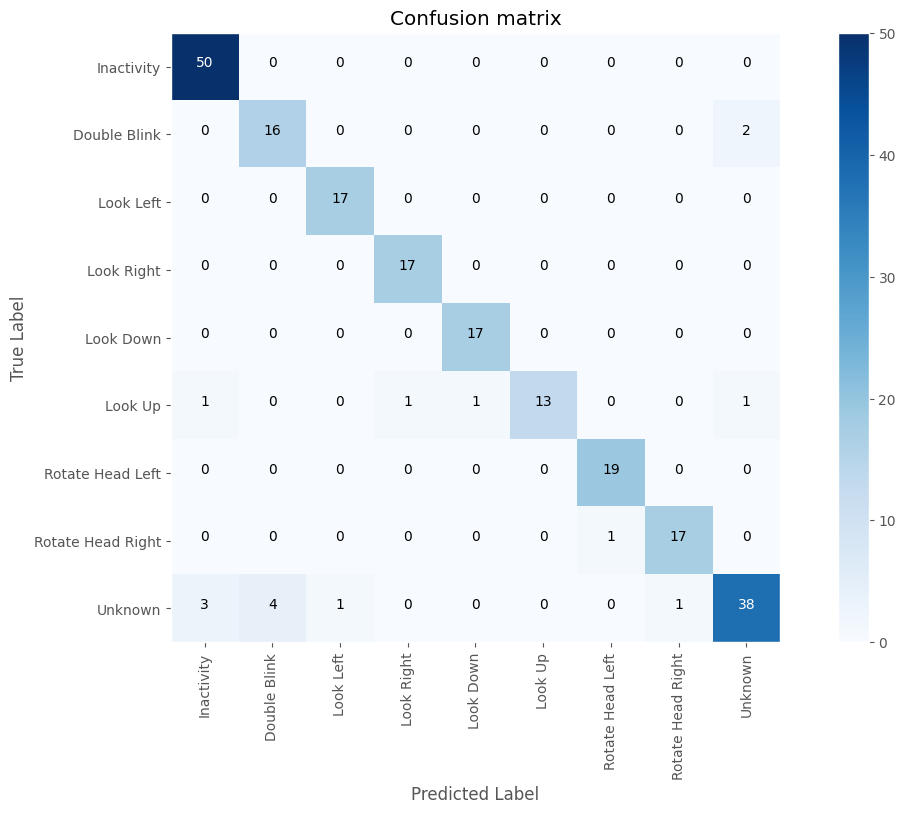

                   precision    recall  f1-score   support

       Inactivity       0.93      1.00      0.96        50
     Double Blink       0.80      0.89      0.84        18
        Look Left       0.94      1.00      0.97        17
       Look Right       0.94      1.00      0.97        17
        Look Down       0.94      1.00      0.97        17
          Look Up       1.00      0.76      0.87        17
 Rotate Head Left       0.95      1.00      0.97        19
Rotate Head Right       0.94      0.94      0.94        18
          Unknown       0.93      0.81      0.86        47

         accuracy                           0.93       220
        macro avg       0.93      0.93      0.93       220
     weighted avg       0.93      0.93      0.93       220

Predictions Threshold (80%) Pass:  206
Average prediction time for a sample in (ms): 45.04724415865812


In [ ]:
loaded_cnn_model = tf.keras.models.load_model("MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_1")

# Make predictions on the test data
cnn_predictions = np.argmax(loaded_cnn_model.predict(cnn_X_test, batch_size=1), axis=-1)
plot_Confusion_Matrix(cnn_y_test, cnn_predictions, LABEL_NAMES)
print(classification_report(cnn_y_test, cnn_predictions, target_names=LABEL_NAMES))

# Also lets check the inference time for predictions and threshold.

cnn_keep_inference_times = []
threshold = 0.8
threshold_counter = 0

for i in range(cnn_X_test.shape[0]):
    move_to_predict = np.expand_dims(cnn_X_test[i], axis=0)
    start_time = time.time()
    cnn_sample_prediction = loaded_cnn_model.predict(move_to_predict, batch_size=1,verbose=0)
    end_time = time.time()
    if (max(cnn_sample_prediction[0]) >= threshold): # Here the [0] is cause we have a nested list as return, but we only check one sample per time
        threshold_counter += 1
    cnn_keep_inference_times.append(end_time - start_time)

print('Predictions Threshold (80%) Pass: ',threshold_counter)
print("Average prediction time for a sample in (ms):", 1000*np.mean(cnn_keep_inference_times))

## CNN-LSTM Model

------------------------------------------------------------------------
Input Shape: (768, 192, 6)
Model: "CNN-LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 128)           15488     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                  

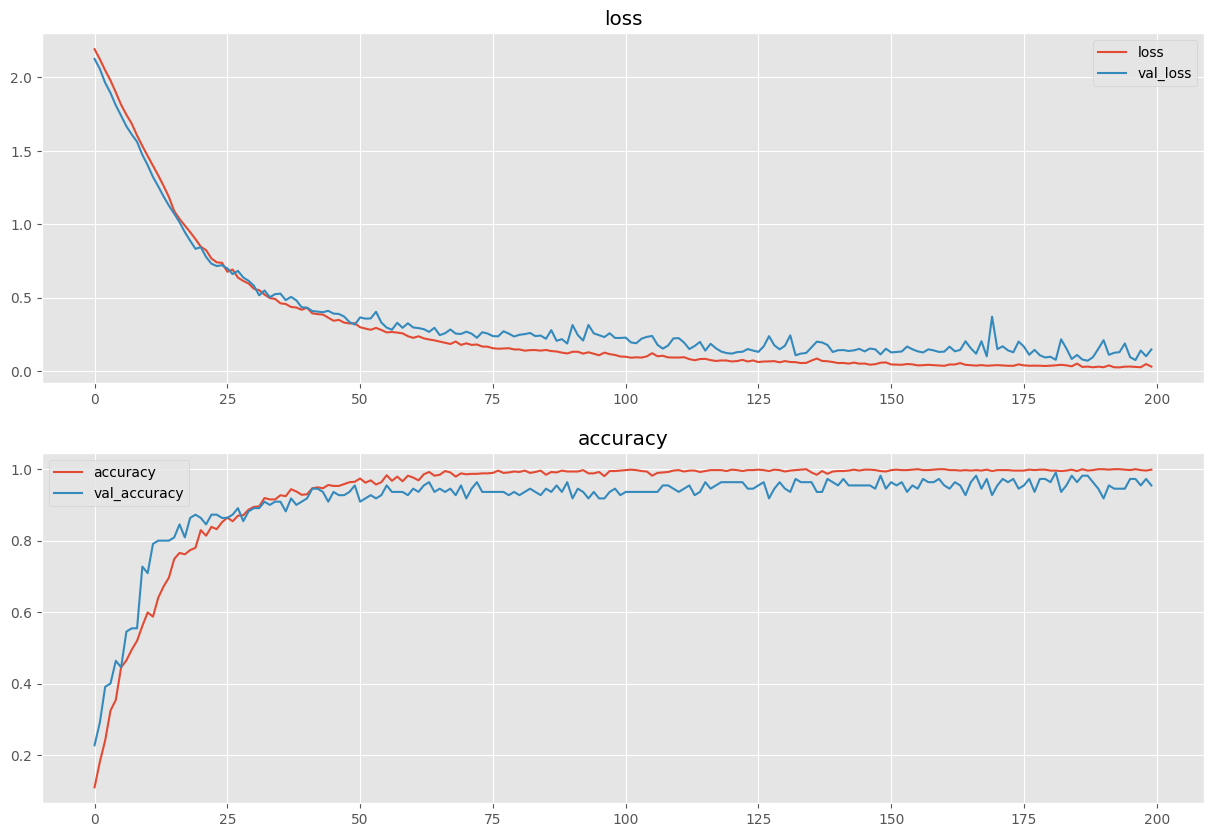

Validation Loss:  0.14920078217983246
Validation Accuracy: 95.45%
Test Loss:  0.2967122793197632
Test Accuracy: 94.09%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_1\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_1\assets


CV Iteration 2/8


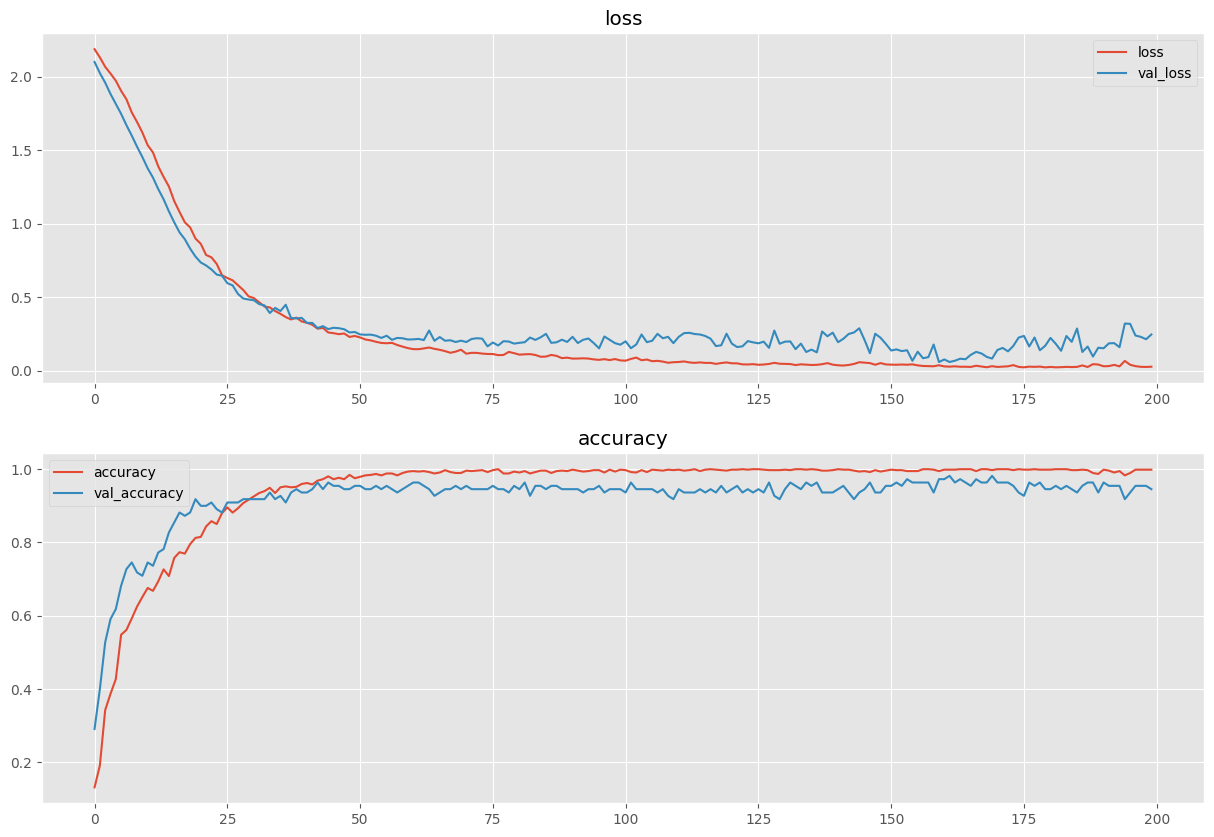

Validation Loss:  0.24579675495624542
Validation Accuracy: 94.55%
Test Loss:  0.31613877415657043
Test Accuracy: 93.18%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_2\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_2\assets


CV Iteration 3/8


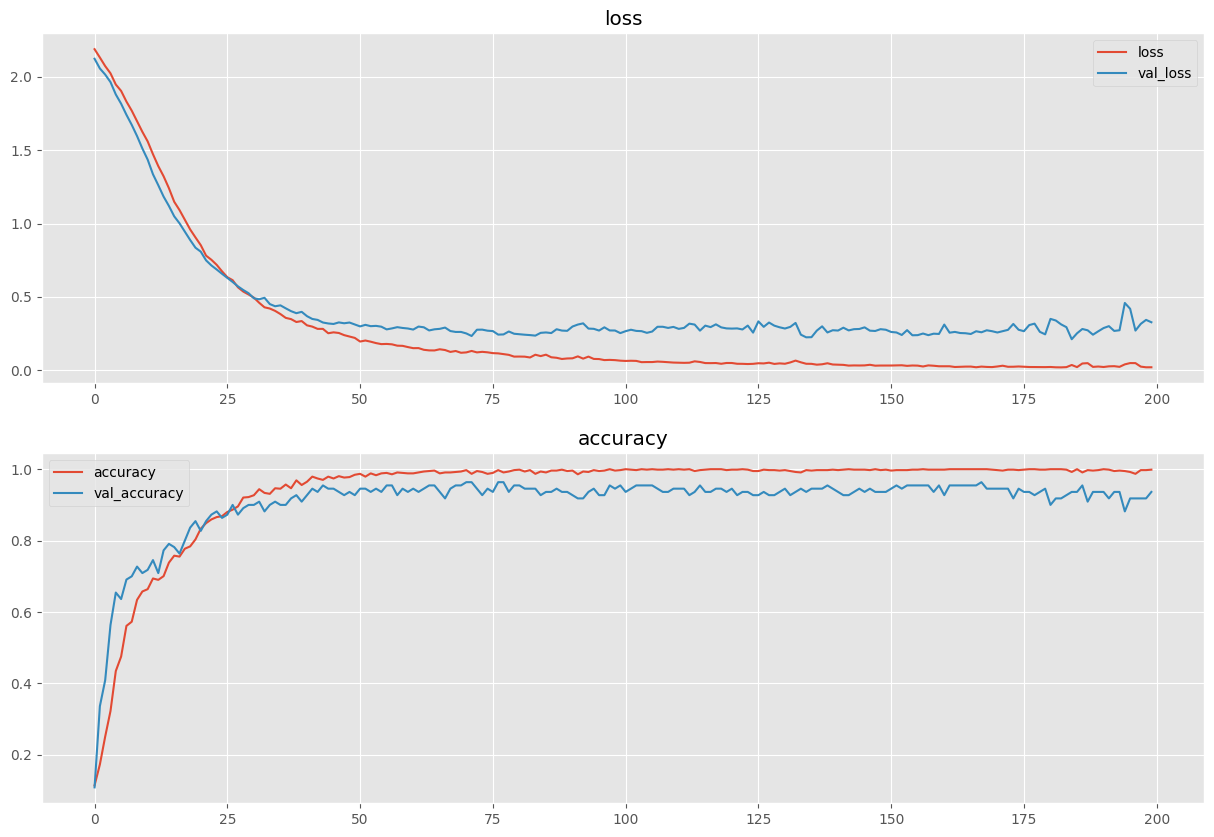

Validation Loss:  0.32742762565612793
Validation Accuracy: 93.64%
Test Loss:  0.2998114228248596
Test Accuracy: 95.00%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_3\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_3\assets


CV Iteration 4/8


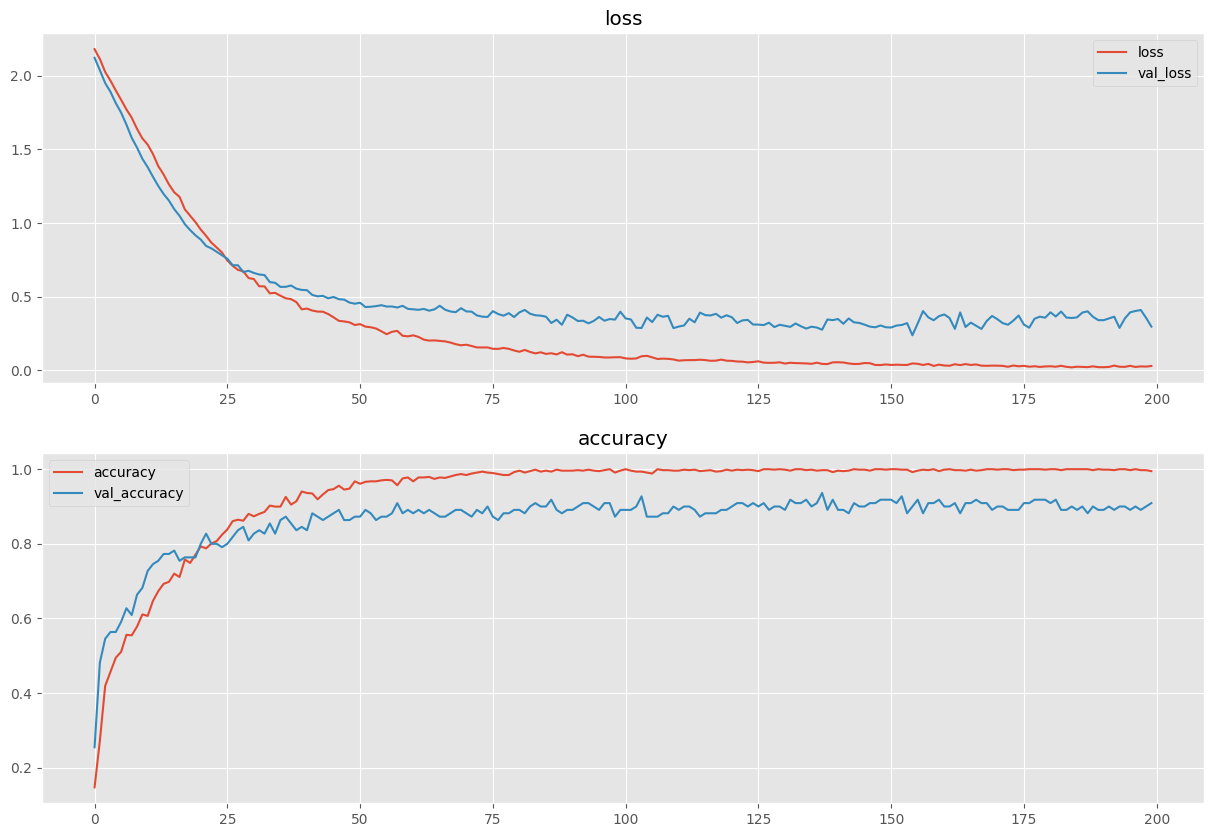

Validation Loss:  0.29717254638671875
Validation Accuracy: 90.91%
Test Loss:  0.25823014974594116
Test Accuracy: 93.64%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_4\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_4\assets


CV Iteration 5/8


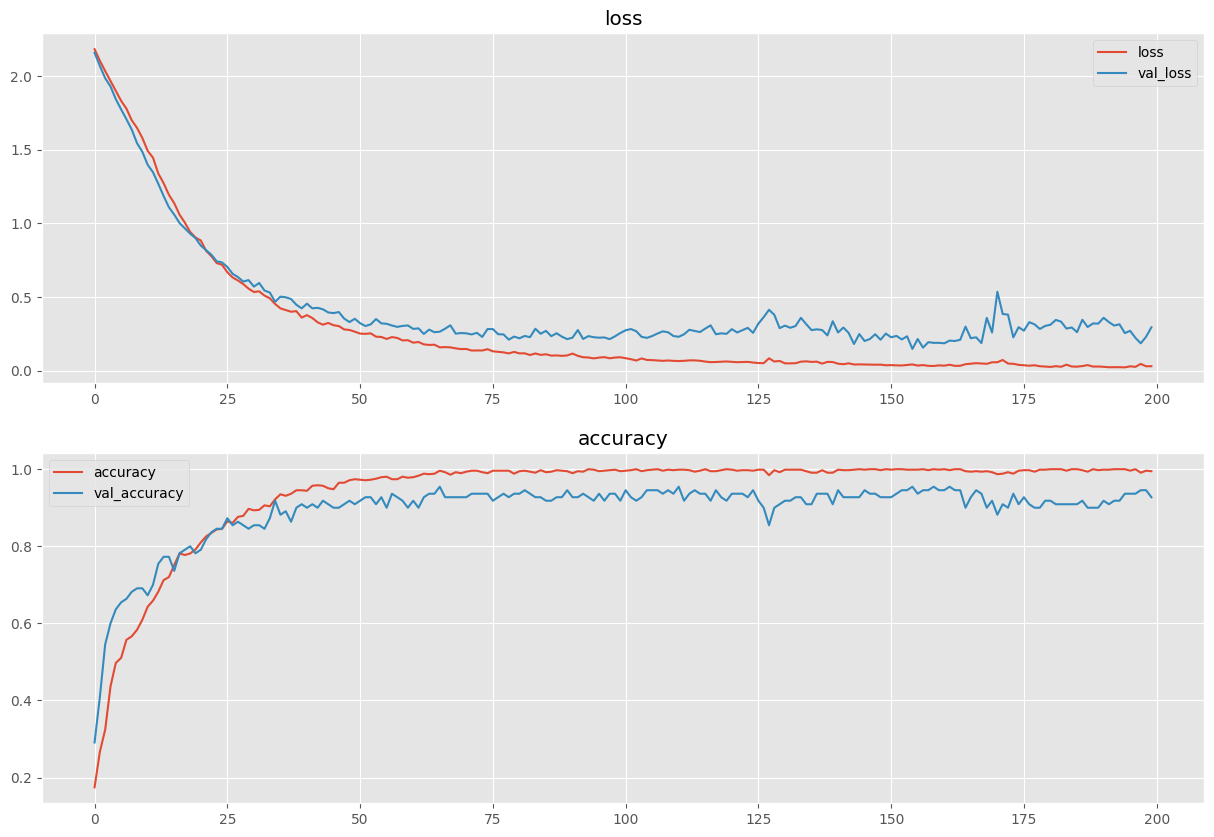

Validation Loss:  0.2939545810222626
Validation Accuracy: 92.73%
Test Loss:  0.3392130434513092
Test Accuracy: 91.82%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_5\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_5\assets


CV Iteration 6/8


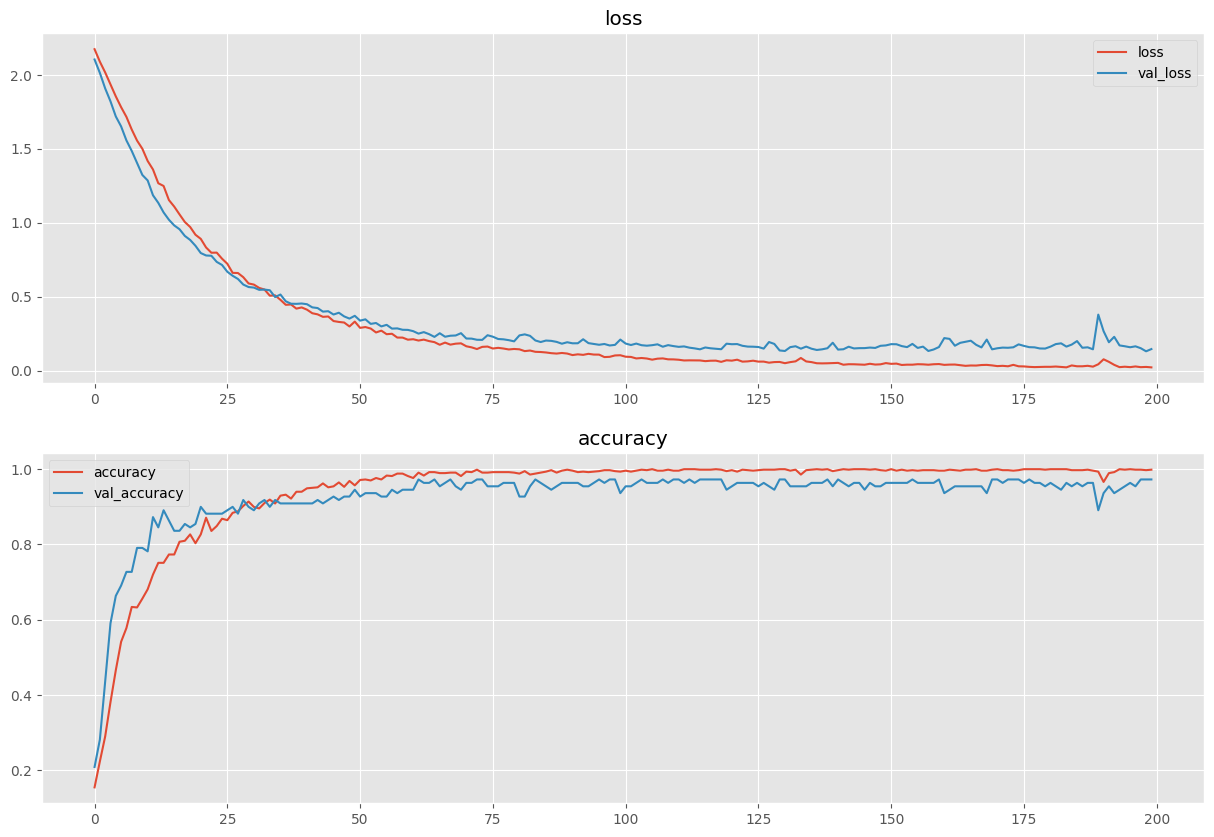

Validation Loss:  0.14600299298763275
Validation Accuracy: 97.27%
Test Loss:  0.2652794122695923
Test Accuracy: 93.64%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_6\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_6\assets


CV Iteration 7/8


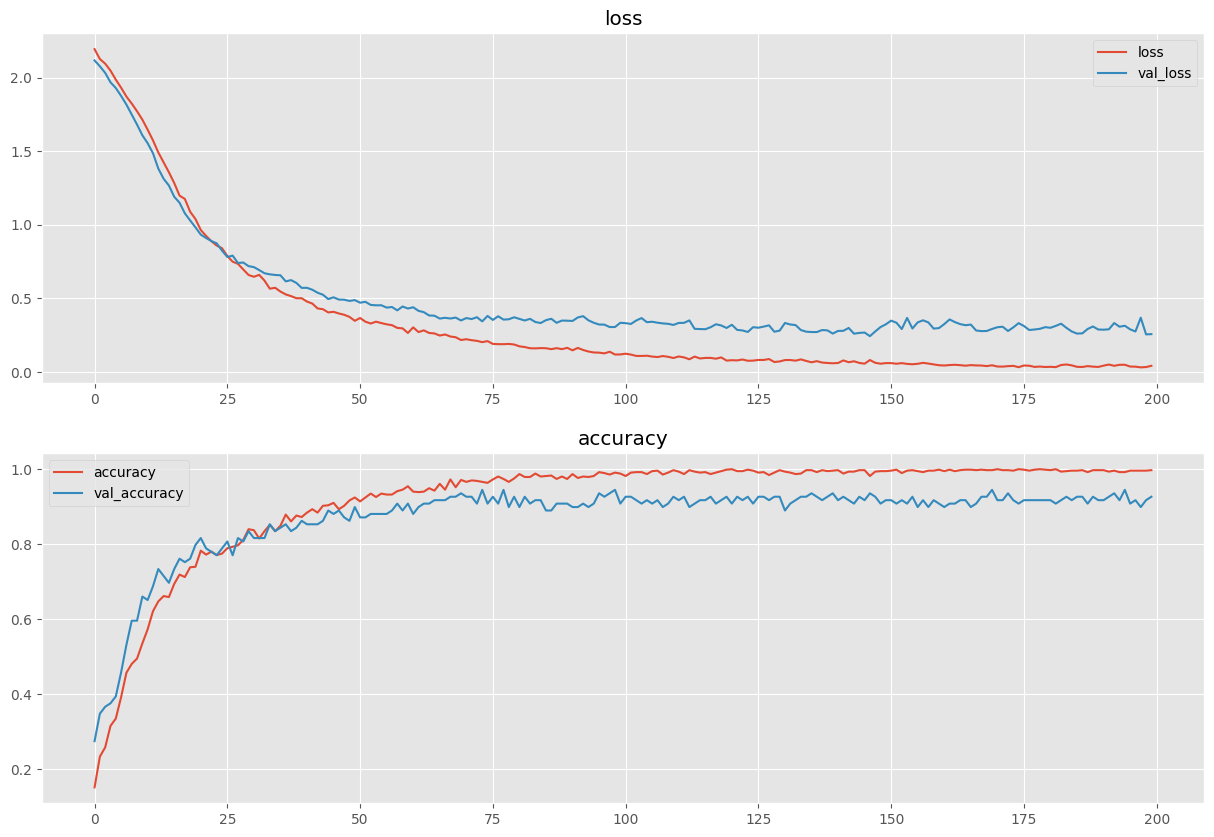

Validation Loss:  0.257251501083374
Validation Accuracy: 92.66%
Test Loss:  0.2690944969654083
Test Accuracy: 93.64%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_7\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_7\assets


CV Iteration 8/8


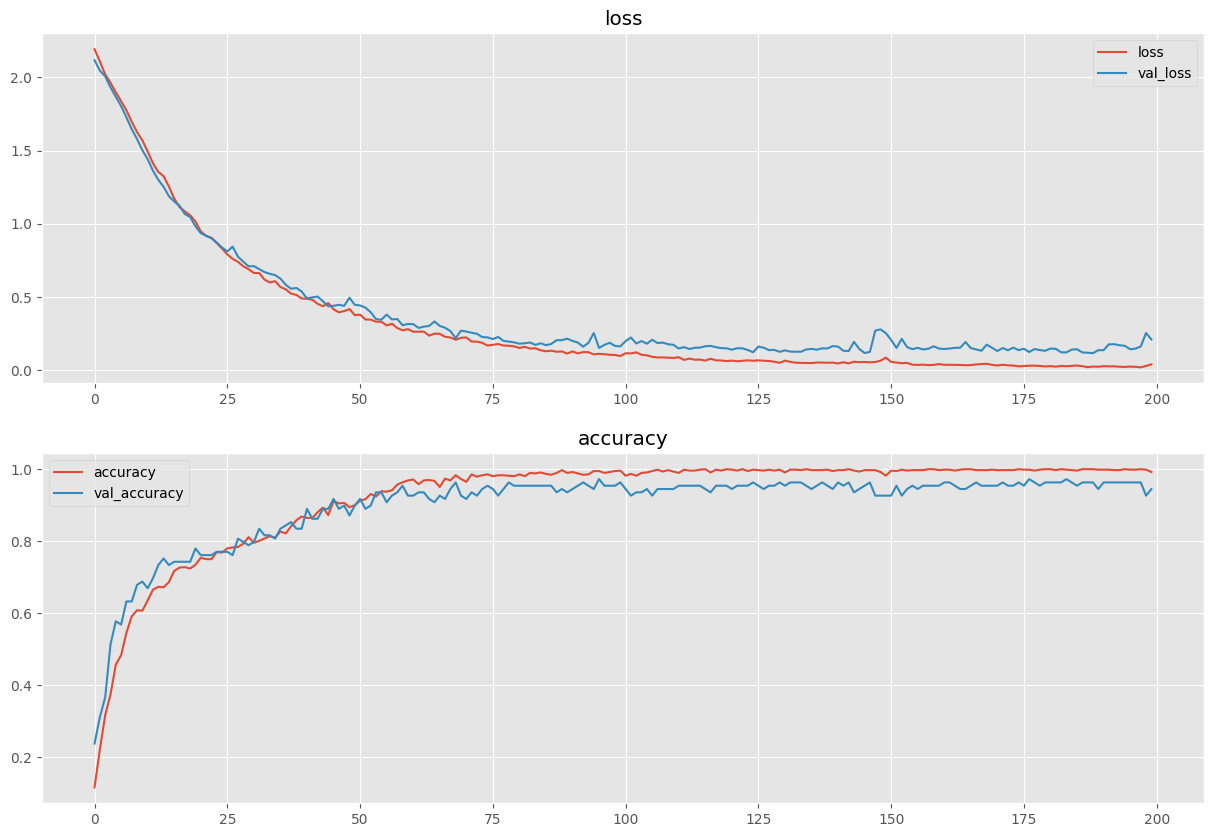

Validation Loss:  0.21081238985061646
Validation Accuracy: 94.50%
Test Loss:  0.25930529832839966
Test Accuracy: 94.55%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_8\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_8\assets


------------------------------------------------------------------------
CV Mean Validation Loss: 0.2409523967653513
CV Mean Validation Accuracy: 93.96% sd: 1.82%
CV Mean Test Loss: 0.2879731096327305
CV Mean Test Accuracy: 93.69% sd: 0.89%


In [ ]:
def create_CNN_LSTM_model(model_input:tuple,model_output:int):
    model = tf.keras.models.Sequential(name='CNN-LSTM_model') # Define model architecture
    # Input Layer
    model.add(tf.keras.layers.InputLayer(input_shape = model_input))

    # Add CNN and Pooling layers
    model.add(tf.keras.layers.Conv1D(filters = 128, kernel_size = 20, strides = 4, activation='relu',padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, activation='relu',padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size = 4, strides=2))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))

    # Add LSTM layers
    model.add(tf.keras.layers.LSTM(32, return_sequences = True, stateful = False))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))
    model.add(tf.keras.layers.LSTM(16, return_sequences = False, stateful = False))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))

    model.add(tf.keras.layers.Dense(model_output, activation = 'softmax'))

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
                metrics=["accuracy"])
    return model

def convert_X_data_to_3D_array(df_list):
    num_samples = len(df_list)
    timesteps, channels = df_list[0].shape
    result_array = np.zeros((num_samples, timesteps, channels))
    for i, df in enumerate(df_list): result_array[i] = df.to_numpy()
    return result_array

cnn_lstm_cv_histories = [] # Save the history of each iteration in cv
cnn_lstm_cv_val_accuracy = [] # Save the validation accuracy of each iteration in cv
cnn_lstm_cv_val_loss = [] # Save the validation loss of each iteration in cv
cnn_lstm_cv_test_accuracy = [] # Save the test accuracy of each iteration in cv
cnn_lstm_cv_test_loss = [] # Save the test loss of each iteration in cv

for i, ((X_train_folds, y_train_folds), (X_val_fold, y_val_fold)) in enumerate(cv_train_val_data):
    tf.keras.backend.clear_session() # Reset the session

    # Convert X data to 3D numpy arrays (samples,timesteps, channels) and labels to 1D numpy arrays
    cnn_lstm_X_train, cnn_lstm_y_train = convert_X_data_to_3D_array(X_train_folds), np.array(y_train_folds)
    cnn_lstm_X_val, cnn_lstm_y_val = convert_X_data_to_3D_array(X_val_fold), np.array(y_val_fold)

    # Define input and outpout shape for the model
    input_size = (cnn_lstm_X_train.shape[1], cnn_lstm_X_train.shape[2])
    output_size = np.max(cnn_lstm_y_val) + 1 # Number of categories:9

    # Create & compile model
    model = create_CNN_LSTM_model(model_input = input_size, model_output = output_size)

    if i == 0: # Plot the model
        print('------------------------------------------------------------------------')
        print("Input Shape: " + str(cnn_lstm_X_train.shape))
        print(model.summary())
        #tf.keras.utils.vis_utils.plot_model(model)
        print('------------------------------------------------------------------------')
    print(f"CV Iteration {i+1}/{len(cv_train_val_data)}")

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(cnn_lstm_y_train), y=cnn_lstm_y_train)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Fit the model
    cnn_lstm_history = model.fit(x = cnn_lstm_X_train, y = cnn_lstm_y_train,
                        validation_data=(cnn_lstm_X_val, cnn_lstm_y_val),
                        epochs = EPOCHS, batch_size = BATCH_SIZE,
                        class_weight = class_weights_dict,
                        shuffle = True, verbose = 0)

    plot_history_metrics(cnn_lstm_history, val_split = True, metrics_to_plot=['loss', 'accuracy', 'val_loss', 'val_accuracy'])
    cnn_lstm_cv_histories.append(cnn_lstm_history.history)

    # Evaluate the model with the validation data for each CV Iteration
    cnn_lstm_val_scores = model.evaluate(cnn_lstm_X_val, cnn_lstm_y_val, verbose=0)
    print("Validation Loss: ",  (cnn_lstm_val_scores[0]))
    print("Validation Accuracy: %.2f%%" % (cnn_lstm_val_scores[1]*100))
    cnn_lstm_cv_val_loss.append(cnn_lstm_val_scores[0])
    cnn_lstm_cv_val_accuracy.append(cnn_lstm_val_scores[1]*100)

    # Evaluate the model with the test data for each CV Iteration
    cnn_lstm_X_test, cnn_lstm_y_test = convert_X_data_to_3D_array(X_test), np.array(y_test)
    cnn_lstm_test_scores = model.evaluate(cnn_lstm_X_test, cnn_lstm_y_test, verbose=0)
    print("Test Loss: ",  (cnn_lstm_test_scores[0]))
    print("Test Accuracy: %.2f%%" % (cnn_lstm_test_scores[1]*100))
    cnn_lstm_cv_test_loss.append(cnn_lstm_test_scores[0])
    cnn_lstm_cv_test_accuracy.append(cnn_lstm_test_scores[1]*100)

    cnn_lstm_path = "MY_DATA\Keras_Models\CNN_LSTM"
    model_filename = '\CNN_LSTM-CV_training_Iteration_' + str(i+1)
    if not os.path.exists(cnn_lstm_path): os.makedirs(cnn_lstm_path)
    model.save(cnn_lstm_path + model_filename)


print('------------------------------------------------------------------------')
print("CV Mean Validation Loss: " +  str(np.mean(cnn_lstm_cv_val_loss)))
print("CV Mean Validation Accuracy: %.2f%% sd: %.2f%%" % (np.mean(cnn_lstm_cv_val_accuracy), np.std(cnn_lstm_cv_val_accuracy)))
print("CV Mean Test Loss: " +  str(np.mean(cnn_lstm_cv_test_loss)))
print("CV Mean Test Accuracy: %.2f%% sd: %.2f%%" % (np.mean(cnn_lstm_cv_test_accuracy), np.std(cnn_lstm_cv_test_accuracy)))

- CNN-LSTM Predictions

220/220 [==============================] - 2s 4ms/step

Correct predictions: 207/220


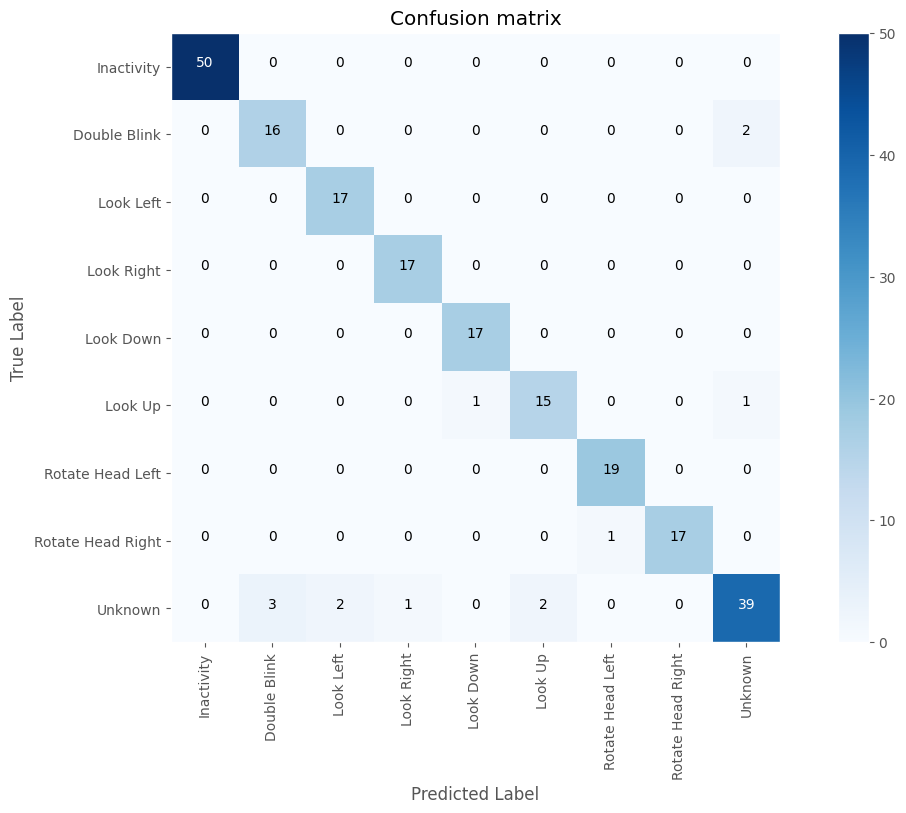

                   precision    recall  f1-score   support

       Inactivity       1.00      1.00      1.00        50
     Double Blink       0.84      0.89      0.86        18
        Look Left       0.89      1.00      0.94        17
       Look Right       0.94      1.00      0.97        17
        Look Down       0.94      1.00      0.97        17
          Look Up       0.88      0.88      0.88        17
 Rotate Head Left       0.95      1.00      0.97        19
Rotate Head Right       1.00      0.94      0.97        18
          Unknown       0.93      0.83      0.88        47

         accuracy                           0.94       220
        macro avg       0.93      0.95      0.94       220
     weighted avg       0.94      0.94      0.94       220

Predictions Threshold (80%) Pass:  219
Average prediction time for a sample in (ms): 46.50607867674394


In [ ]:
loaded_cnn_lstm_model = tf.keras.models.load_model("MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_1")

# Make predictions on the test data
cnn_lstm_predictions = np.argmax(loaded_cnn_lstm_model.predict(cnn_lstm_X_test, batch_size=1), axis=-1)
plot_Confusion_Matrix(cnn_lstm_y_test, cnn_lstm_predictions, LABEL_NAMES)
print(classification_report(cnn_lstm_y_test, cnn_lstm_predictions, target_names=LABEL_NAMES))

# Also lets check the inference time for predictions and threshold.

cnn_lstm_keep_inference_times = []
threshold = 0.8
threshold_counter = 0

for i in range(cnn_lstm_X_test.shape[0]):
    move_to_predict = np.expand_dims(cnn_lstm_X_test[i], axis=0)
    start_time = time.time()
    cnn_lstm_sample_prediction = loaded_cnn_lstm_model.predict(move_to_predict, batch_size=1,verbose=0)
    end_time = time.time()
    if (max(cnn_lstm_sample_prediction[0]) >= threshold): # Here the [0] is cause we have a nested list as return, but we only check one sample per time
        threshold_counter += 1
    cnn_lstm_keep_inference_times.append(end_time - start_time)

print('Predictions Threshold (80%) Pass: ',threshold_counter)
print("Average prediction time for a sample in (ms):", 1000*np.mean(cnn_lstm_keep_inference_times))